## Installation des packages

Les packages Python sont installés automatiquement à partir du fichier `requirements.txt`

In [4]:
# download requirement
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.4 MB/s eta 0:00:

## Téléchargement des données à partir de Kaggle

On télécharge les données grâce à l'API Kaggle de Python

In [2]:
# download dataset zip from Kaggle
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

/bin/bash: line 1: kaggle: command not found


In [ ]:
# unzip data into data folder
!unzip stanford-car-dataset-by-classes-folder.zip -d data/

## Chargement des fichiers csv

In [5]:
import os
import pandas as pd
import s3fs
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def read_csv_file(filename, cols):
    df = pd.read_csv(f'data/{filename}.csv', header=None, names=cols)
    print(df.shape)
    return df

In [7]:
names = read_csv_file('names', cols=['name'])
names['id'] = np.arange(1, 197)
names.head()

(196, 1)


name  id
0  AM General Hummer SUV 2000   1
1         Acura RL Sedan 2012   2
2         Acura TL Sedan 2012   3
3        Acura TL Type-S 2008   4
4        Acura TSX Sedan 2012   5

In [8]:
train = read_csv_file('anno_train', cols=['jpg', 'a', 'b', 'c', 'id'])
print(train['id'].unique().shape)
train.head()

(8144, 5)
(196,)


jpg    a     b     c   id
00001.jpg   39  116   569   375   14
00002.jpg   36  116   868   587    3
00003.jpg   85  109   601   381   91
00004.jpg  621  393  1484  1096  134
00005.jpg   14   36   133    99  106

In [9]:
test = read_csv_file('anno_test', cols=['jpg', 'a', 'b', 'c', 'id'])
print(test['id'].unique().shape)
test.head()

(8041, 5)
(196,)


jpg    a    b    c   id
00001.jpg   30   52  246  147  181
00002.jpg  100   19  576  203  103
00003.jpg   51  105  968  659  145
00004.jpg   67   84  581  407  187
00005.jpg  140  151  593  339  185

### Jointure avec le fichier names
Le but est de récupérer pour chaque données de train et de test, le nom du modèle correspondant

In [10]:
def get_model_name(df, name_df):
    df = pd.merge(df, name_df, on='id')
    df = df.drop(['id'], axis=1)
    return df

In [11]:
train = get_model_name(train, names)
test = get_model_name(test, names)

## Plot de la distribution du nombre de classes

- On cherche à observer si il existe des classes qui sont plus présentent dans nos données.
- En cas de déséquilibre, cela pourrait engendrer un biais

In [85]:
def plot_class_count(df, col, title):
    fig = plt.figure(figsize=(40, 10))

    value_counts = df[col].value_counts().sort_values(ascending=False).reset_index()
    value_counts.columns = [col, 'counts']  
 
    # Tracer l'histogramme avec les valeurs triées
    sns.barplot(data=value_counts, x=col, y='counts', color='grey')    
    plt.xticks(rotation=90)

    value_counts = df[col].value_counts()
    min_val = value_counts.min()
    max_val = value_counts.max()
    mean_val = value_counts.mean()

    # Tracer les lignes pour min, max et mean
    plt.axhline(min_val, color='red', linestyle='--', label='Min')
    plt.axhline(max_val, color='red', linestyle='--', label='Max')
    plt.axhline(mean_val, color='blue', linestyle='--', label='Mean')
    plt.title(title)
    plt.legend()
    plt.show()

In [13]:
def distribution_df(df_train, df_test, col, title):
    fig = plt.figure(figsize=(6, 3))
    train_counts = df_train[col].value_counts()
    test_counts = df_test[col].value_counts()
    
    sns.kdeplot(train_counts, fill=True, label="train set", color='red')
    sns.kdeplot(test_counts, fill=True, label="test set", color='blue')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def create_variable(df):
    df['year'] = df['name'].str.extract(r'(\b\d{4}\b)$')
    df['model_name'] = df['name'].str.replace(r'\b\d{4}\b$', '', regex=True)
    df['marque'] = df['model_name'].str.extract(r'^(\w+(-\w+)?)')[0]
    return df

In [15]:
train = create_variable(train)
test = create_variable(test)
df = pd.concat([train, test])

## Distribution des labels

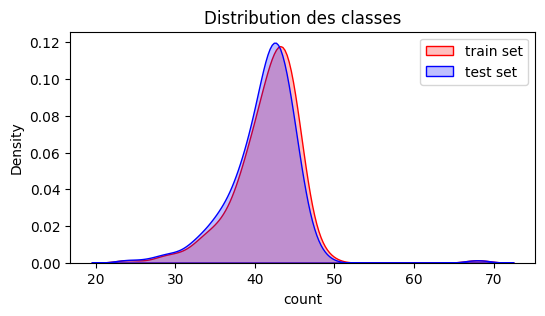

In [40]:
distribution_df(train, test, col='name', title='Distribution des classes')

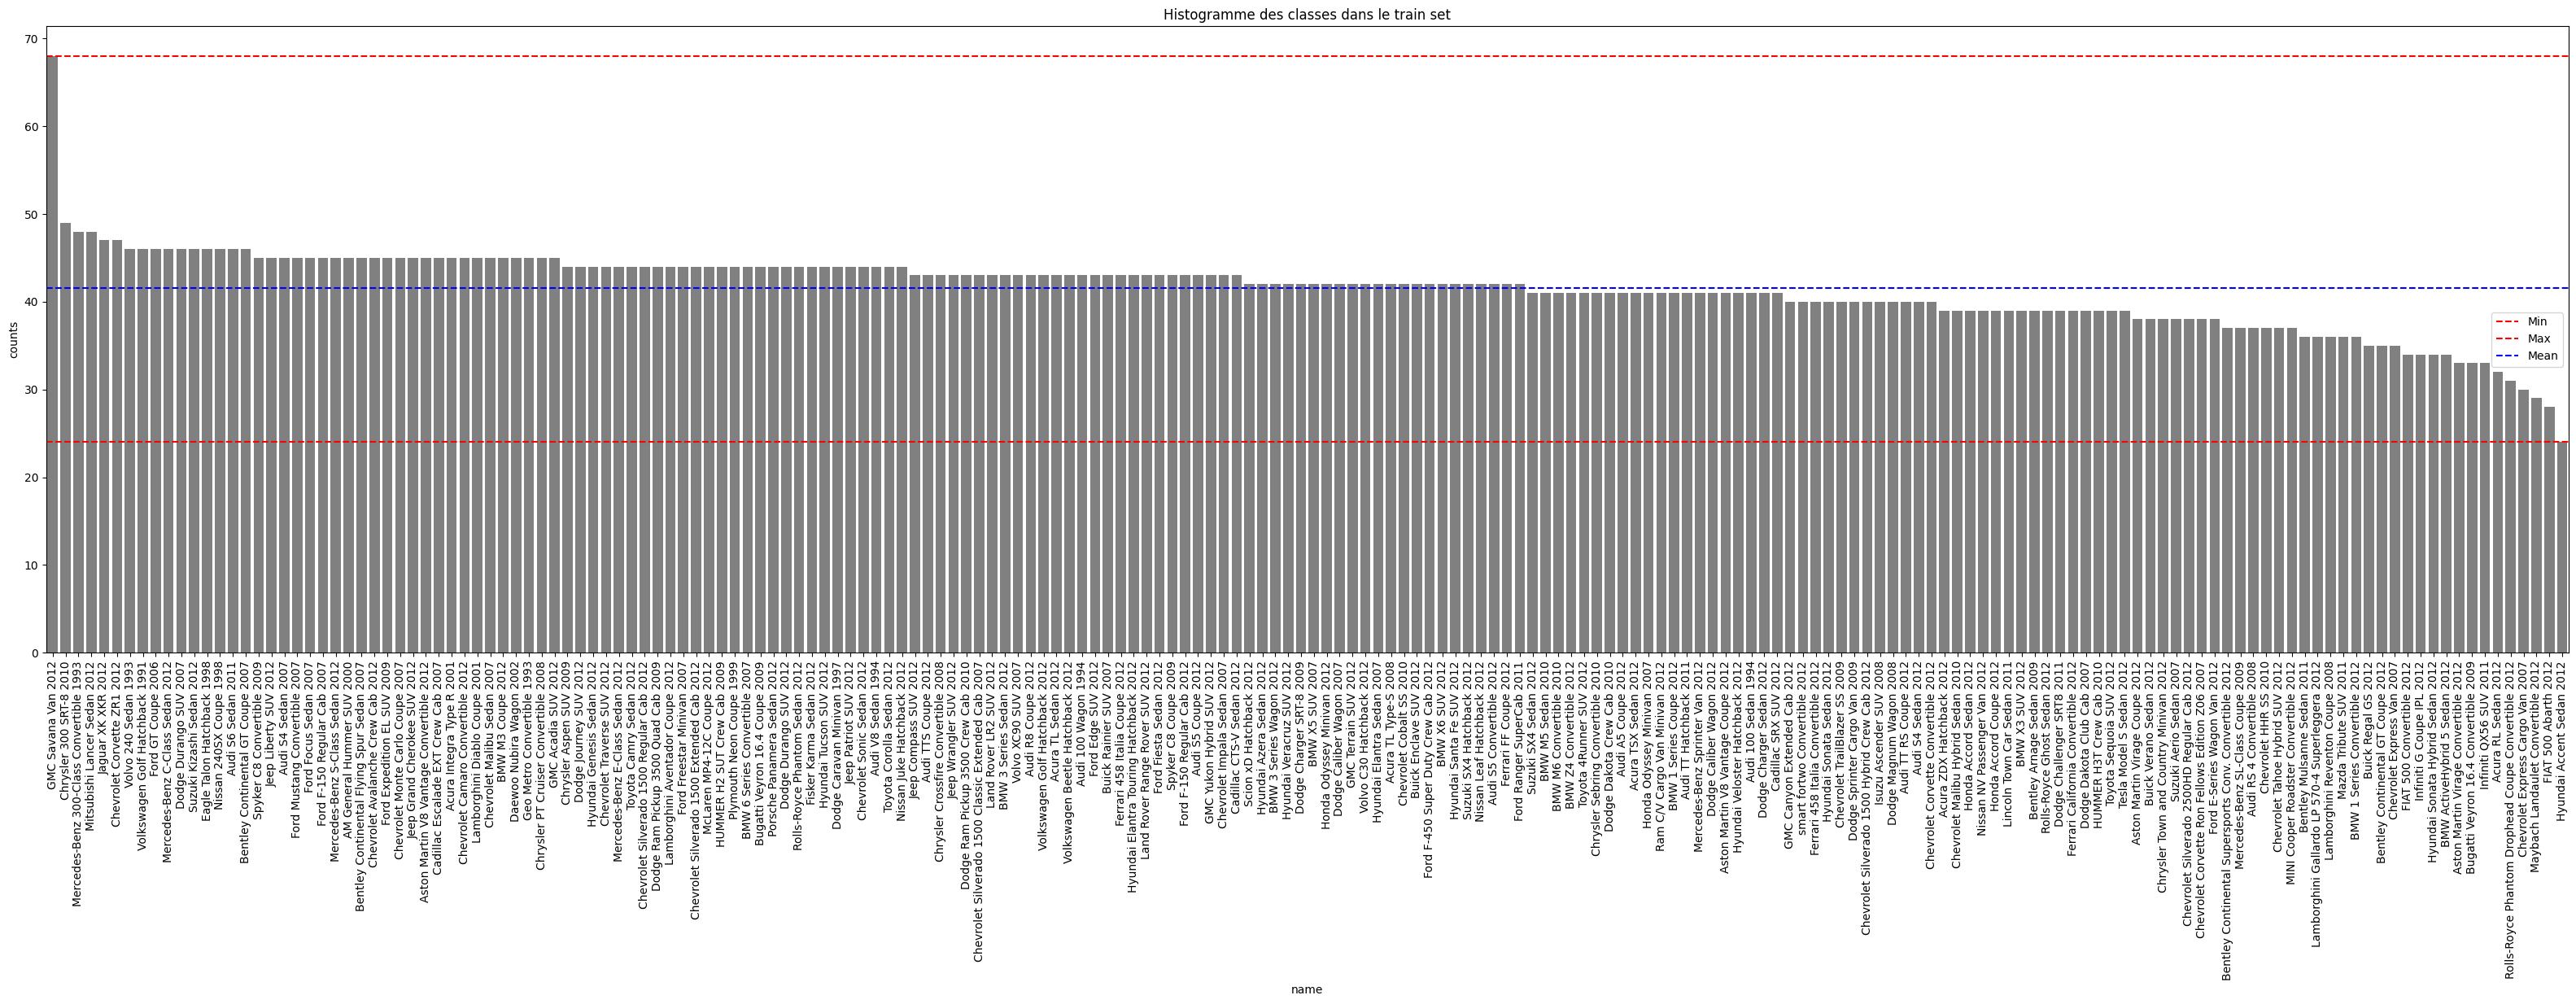

In [86]:
plot_class_count(train, col='name', title='Histogramme des classes dans le train set')

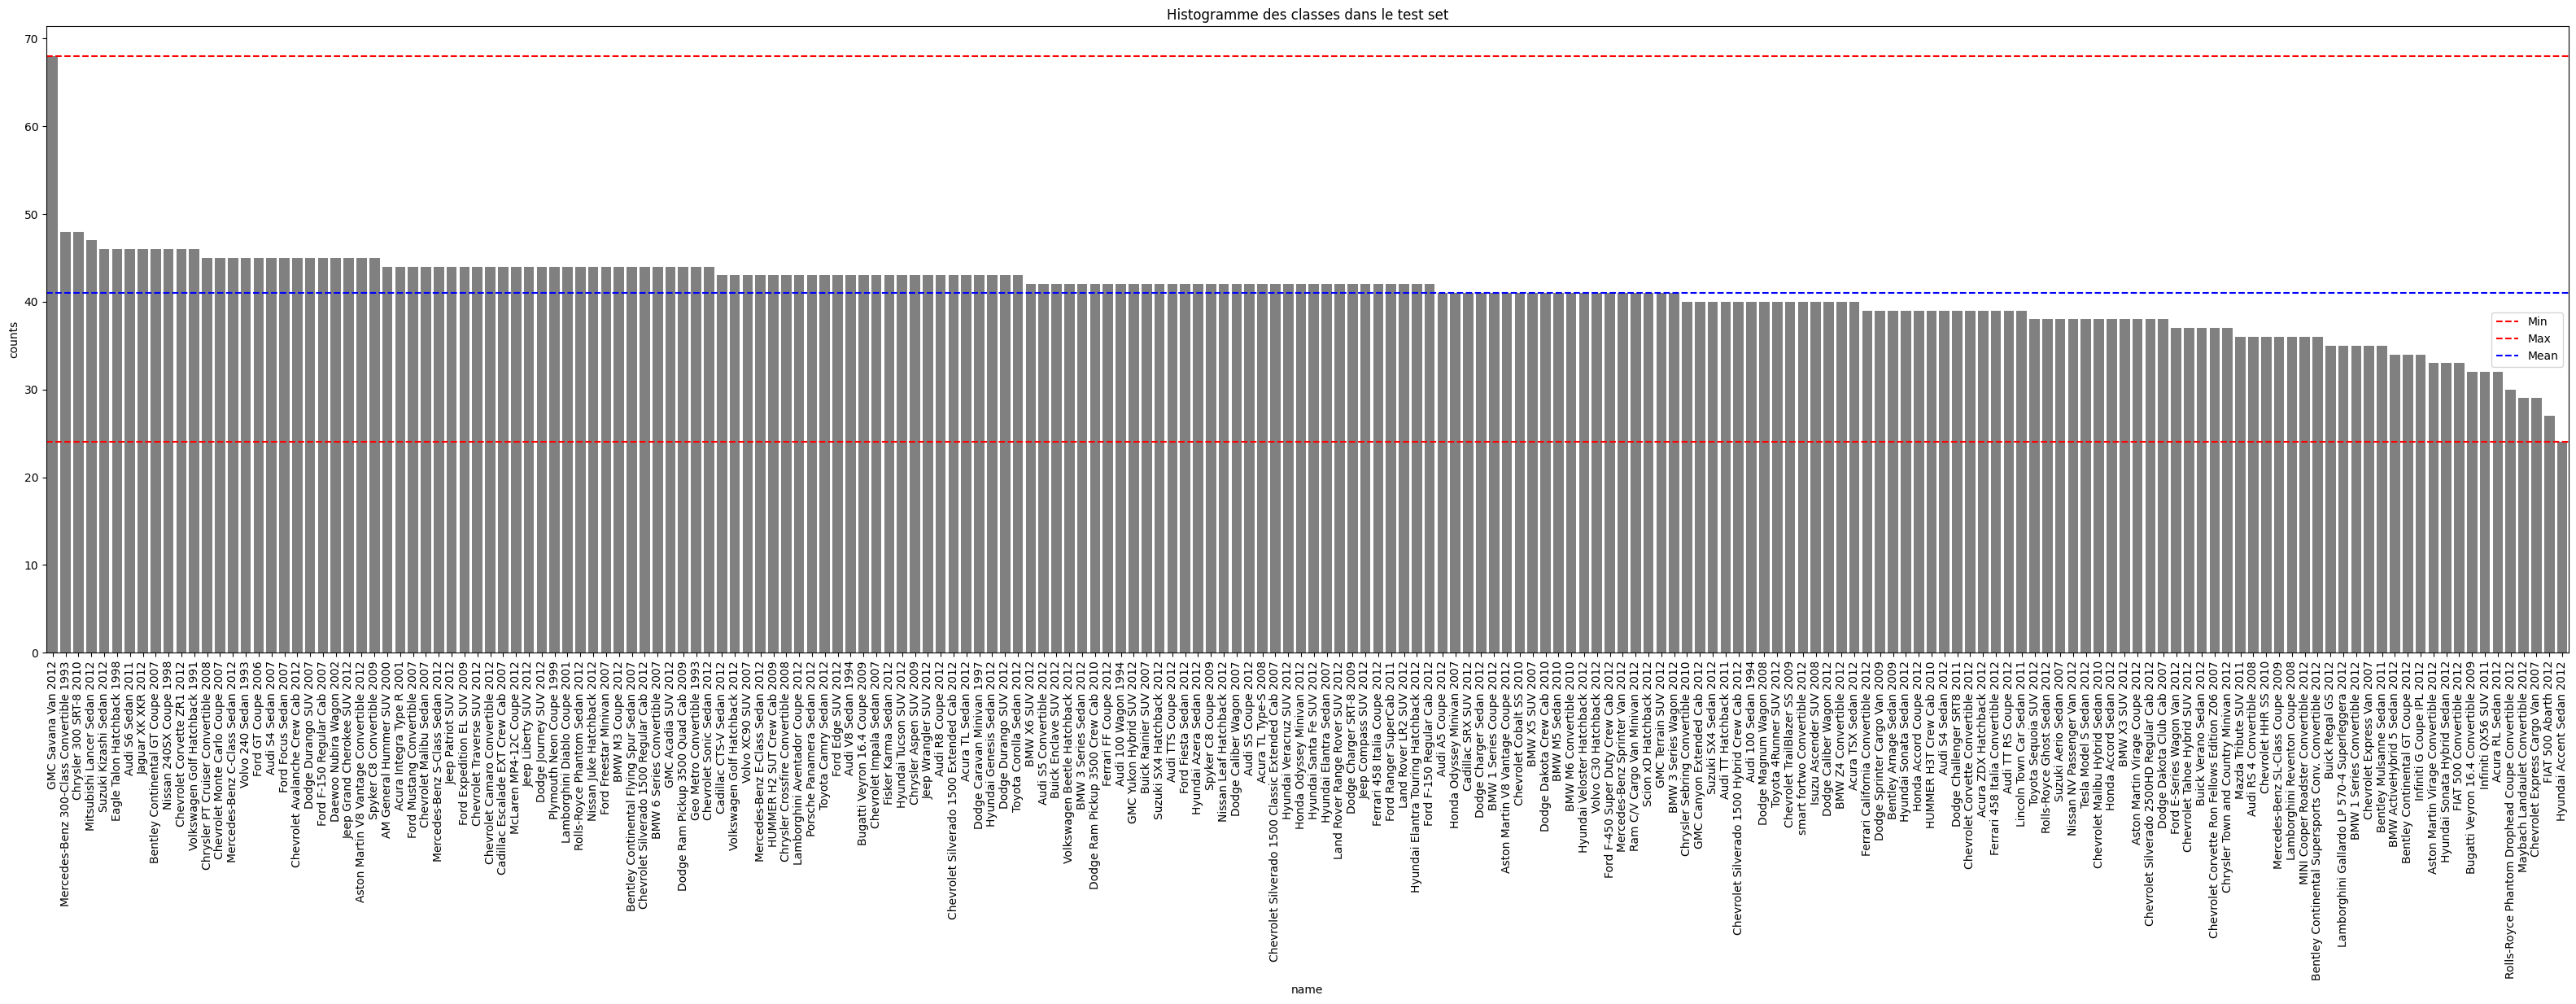

In [23]:
plot_class_count(test, col='name', title='Histogramme des classes dans le test set')

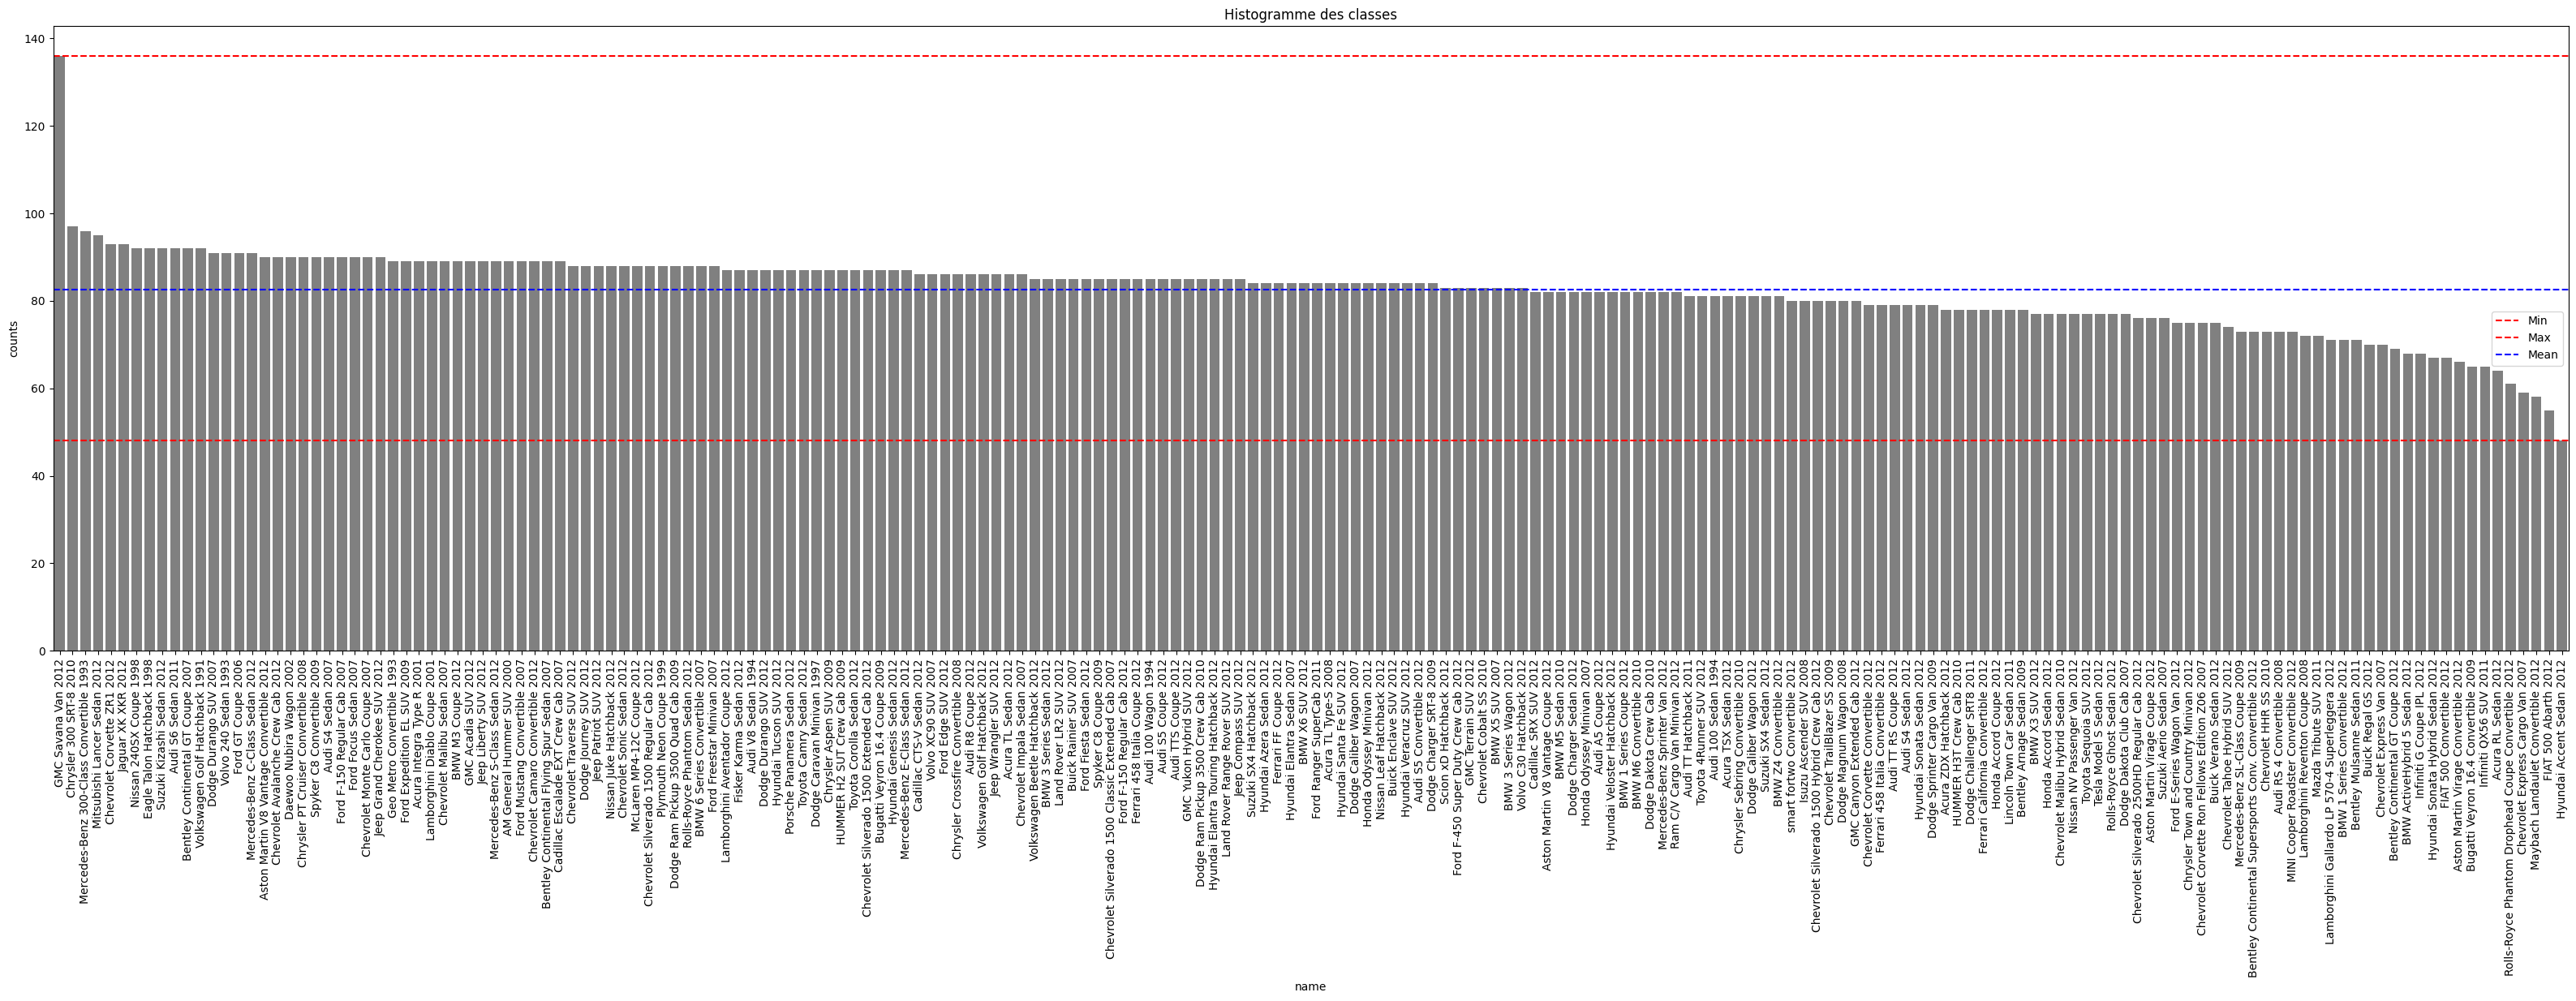

In [24]:
plot_class_count(df, col='name', title='Histogramme des classes')

## Distribution de l'année des modèles

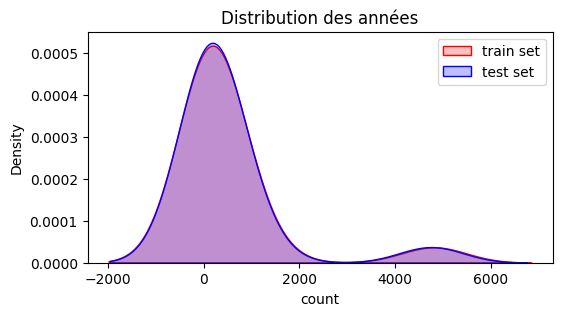

In [25]:
distribution_df(train, test, col='year', title='Distribution des années')

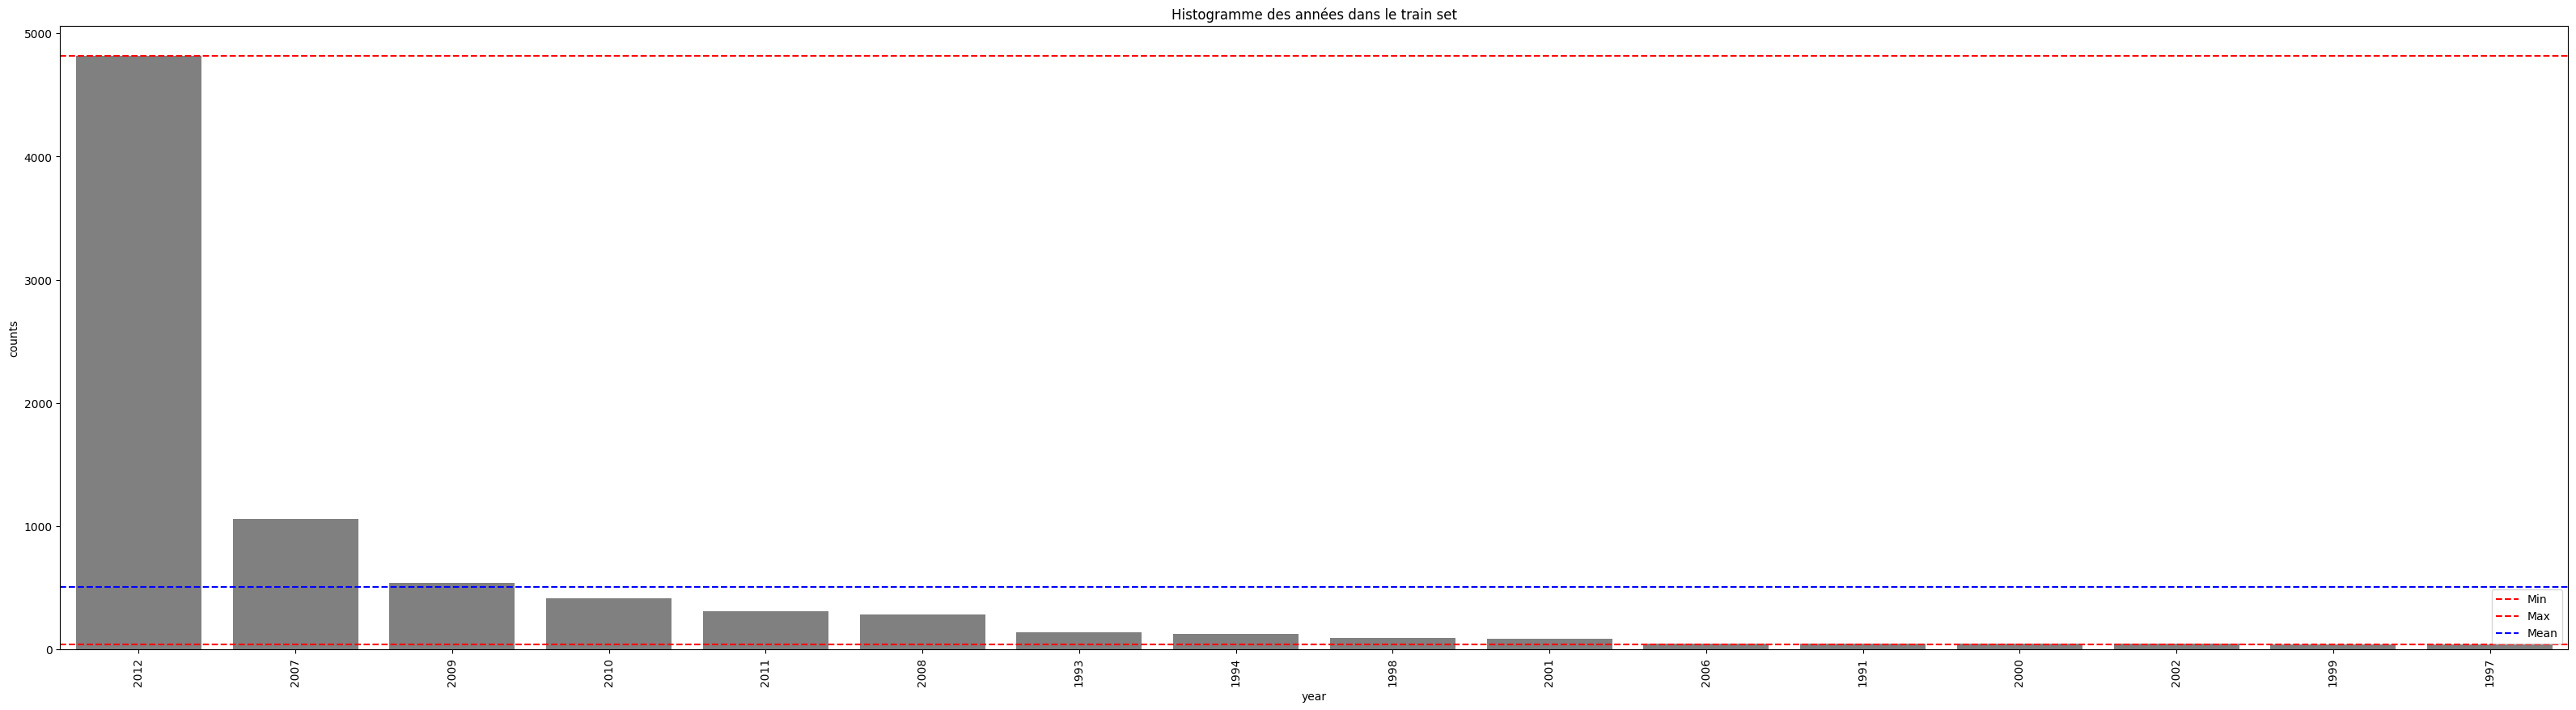

In [26]:
plot_class_count(train, col='year', title='Histogramme des années dans le train set')

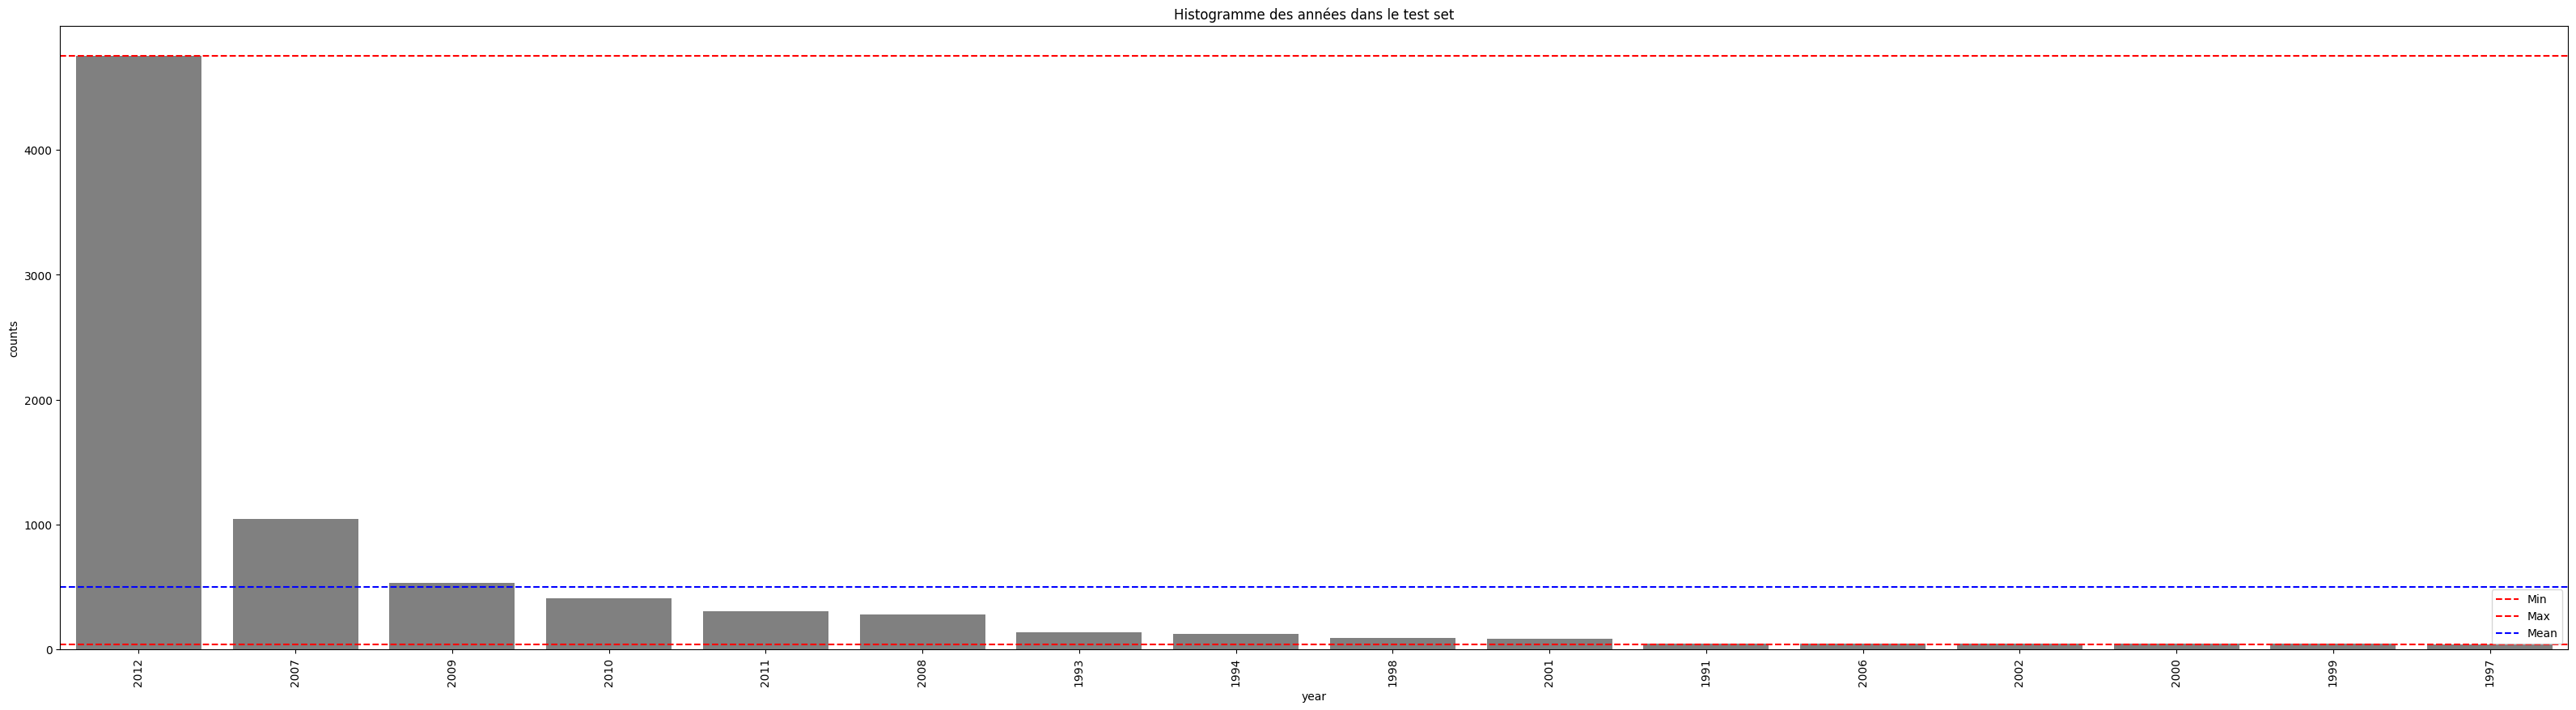

In [27]:
plot_class_count(test, col='year', title='Histogramme des années dans le test set')

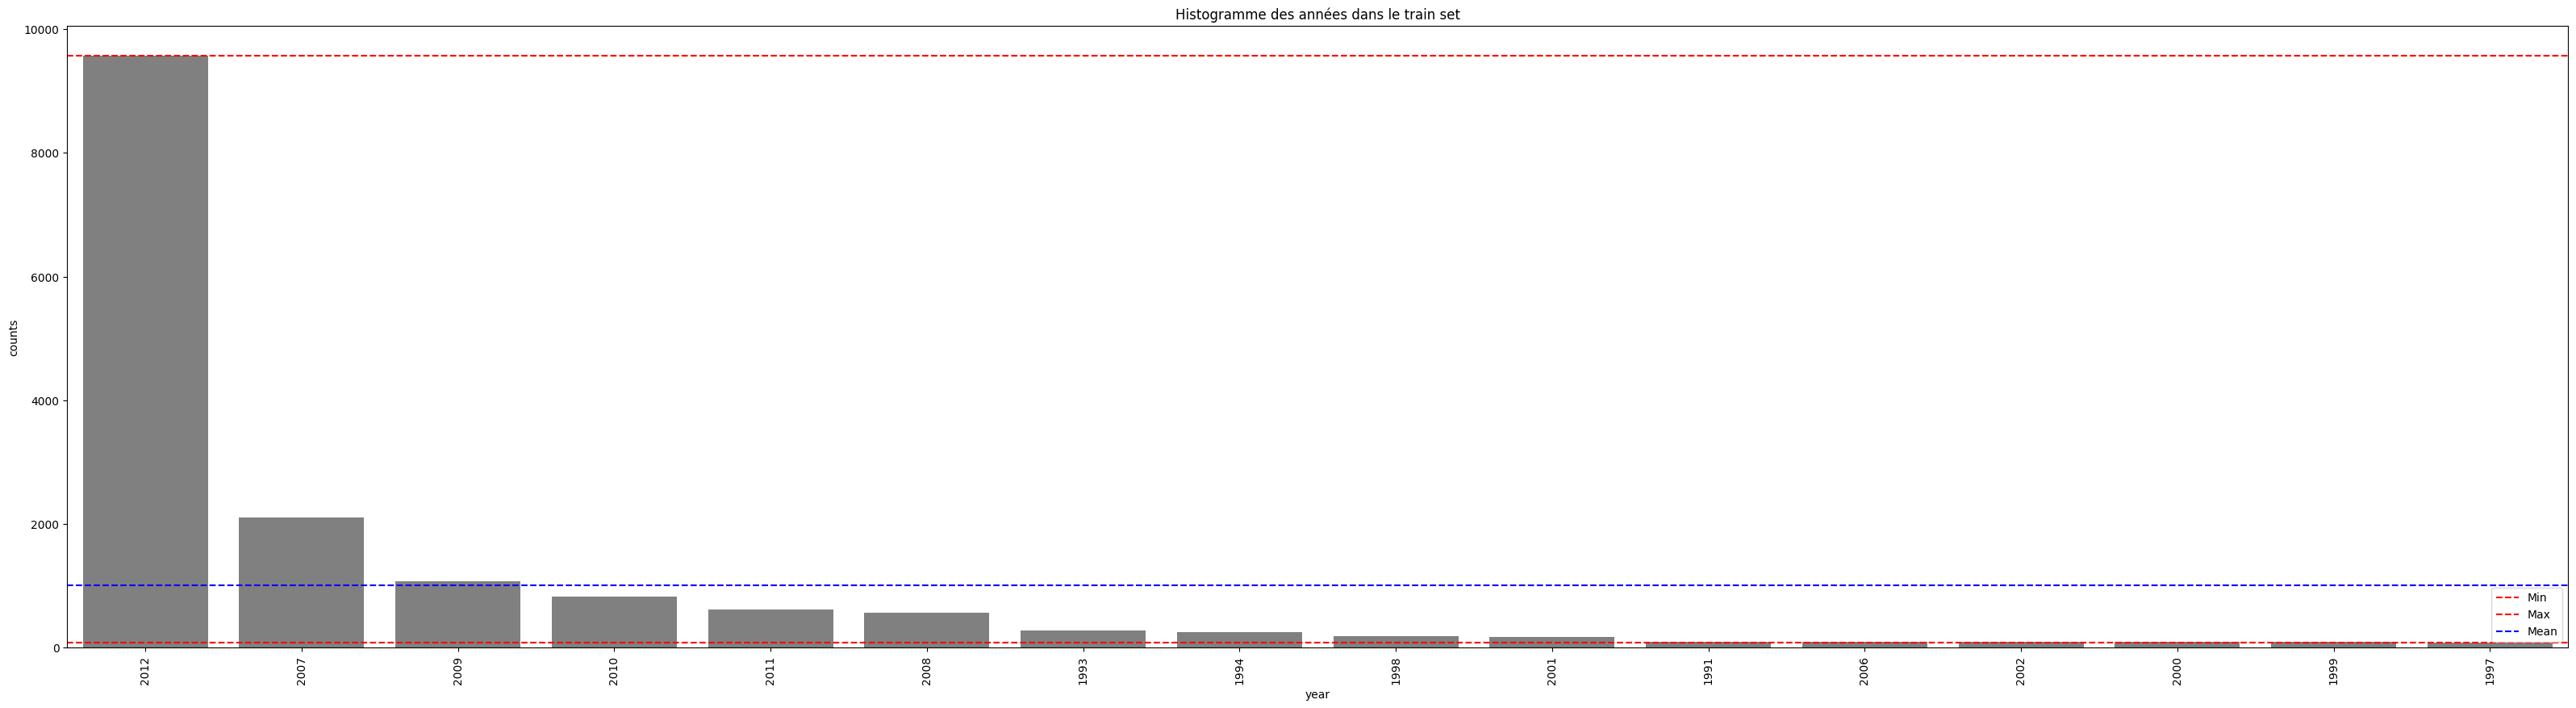

In [28]:
plot_class_count(df, col='year', title='Histogramme des années dans le train set')

## Distribution des modèles sans les années

In [30]:
train['marque'].nunique()

49

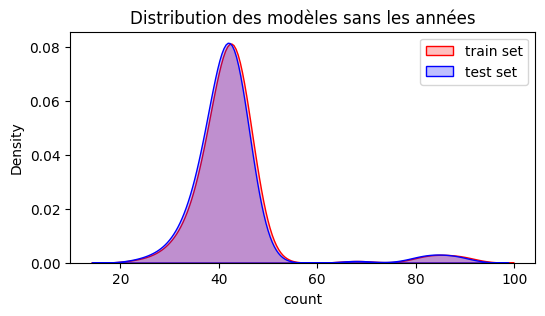

In [313]:
distribution_df(train, test, col='model_name', title='Distribution des modèles sans les années')

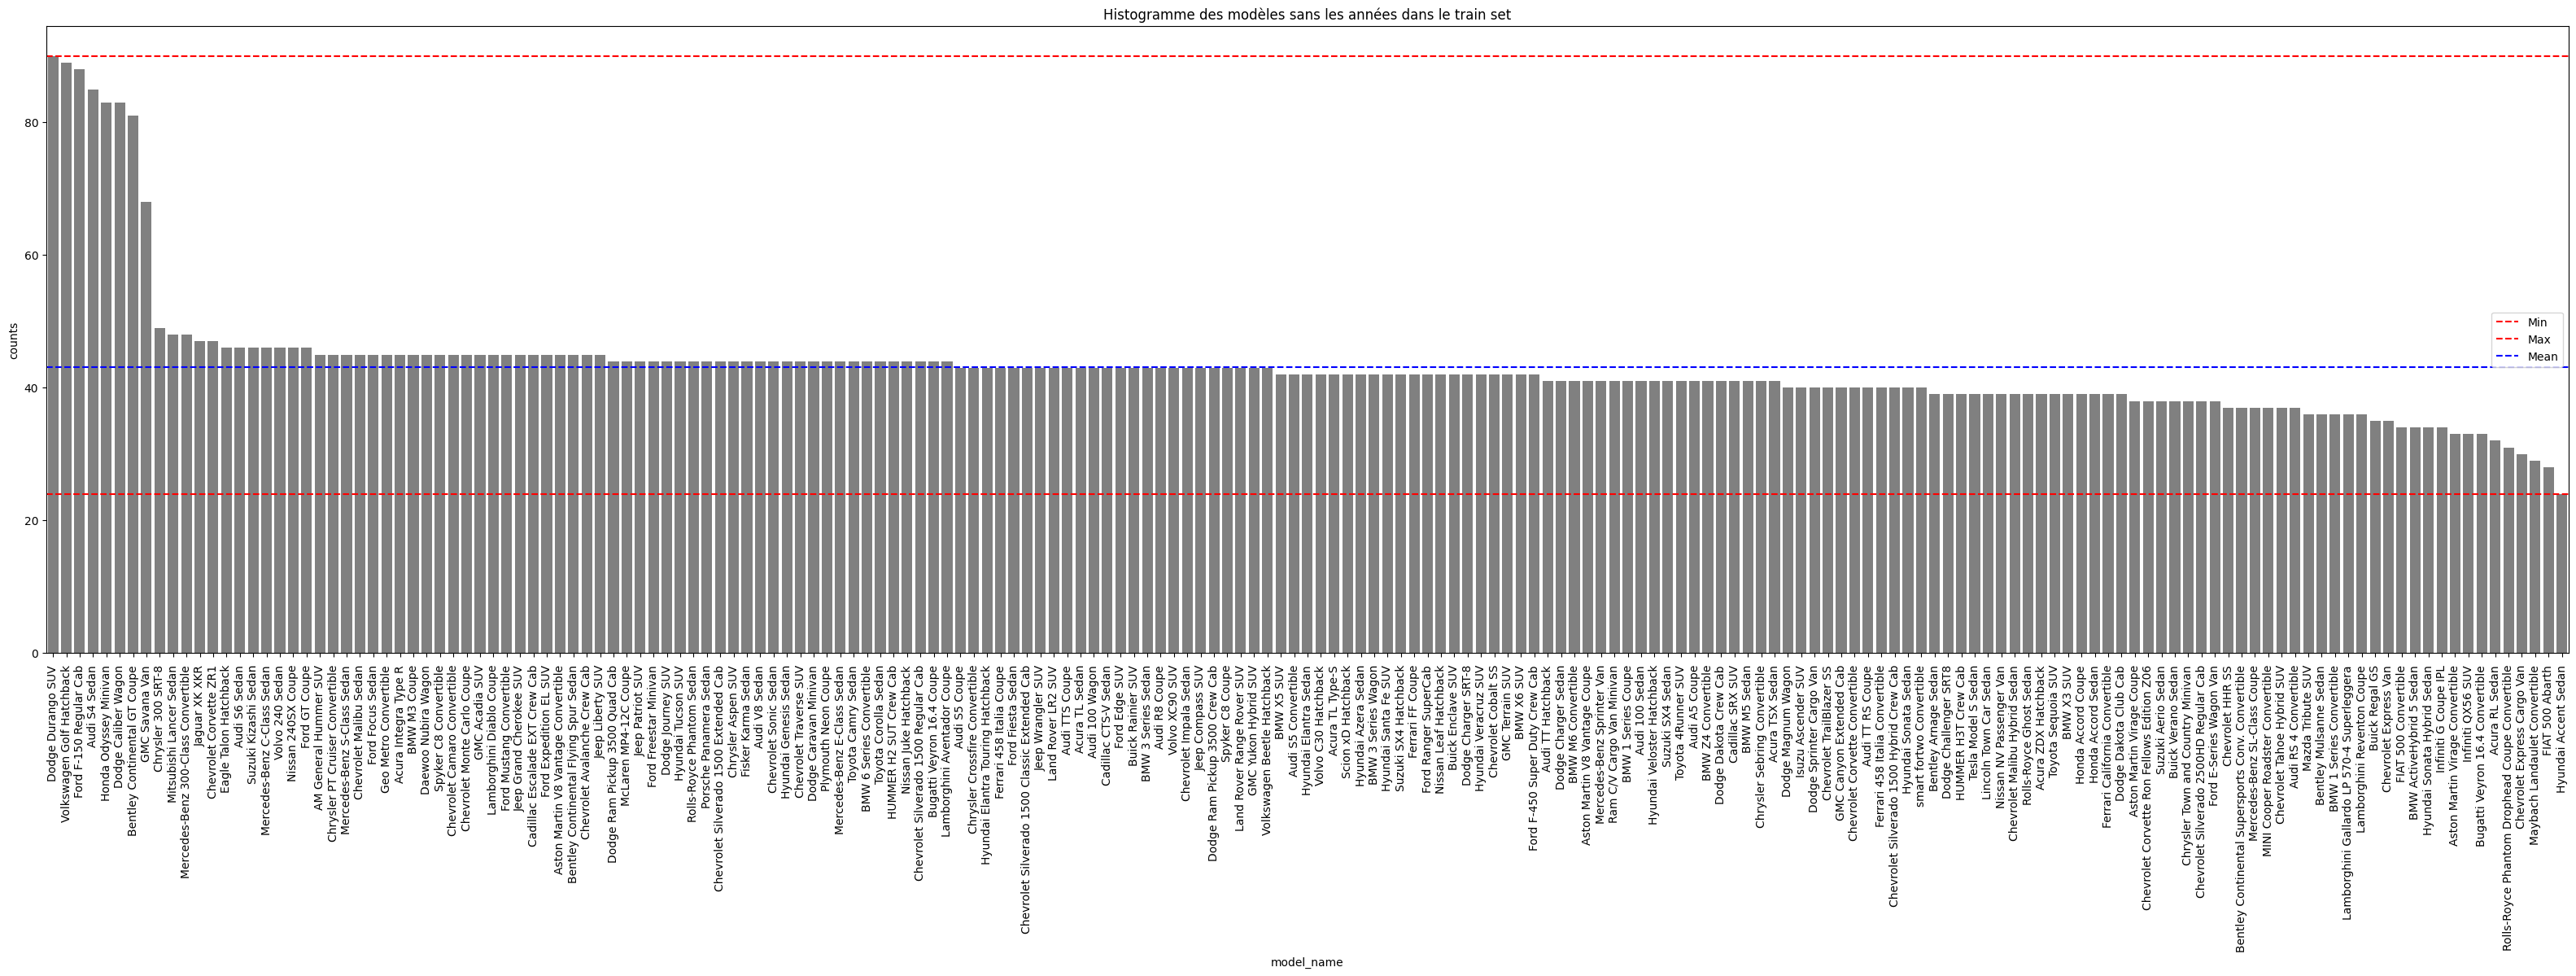

In [315]:
plot_class_count(train, col='model_name', title='Histogramme des modèles sans les années dans le train set')

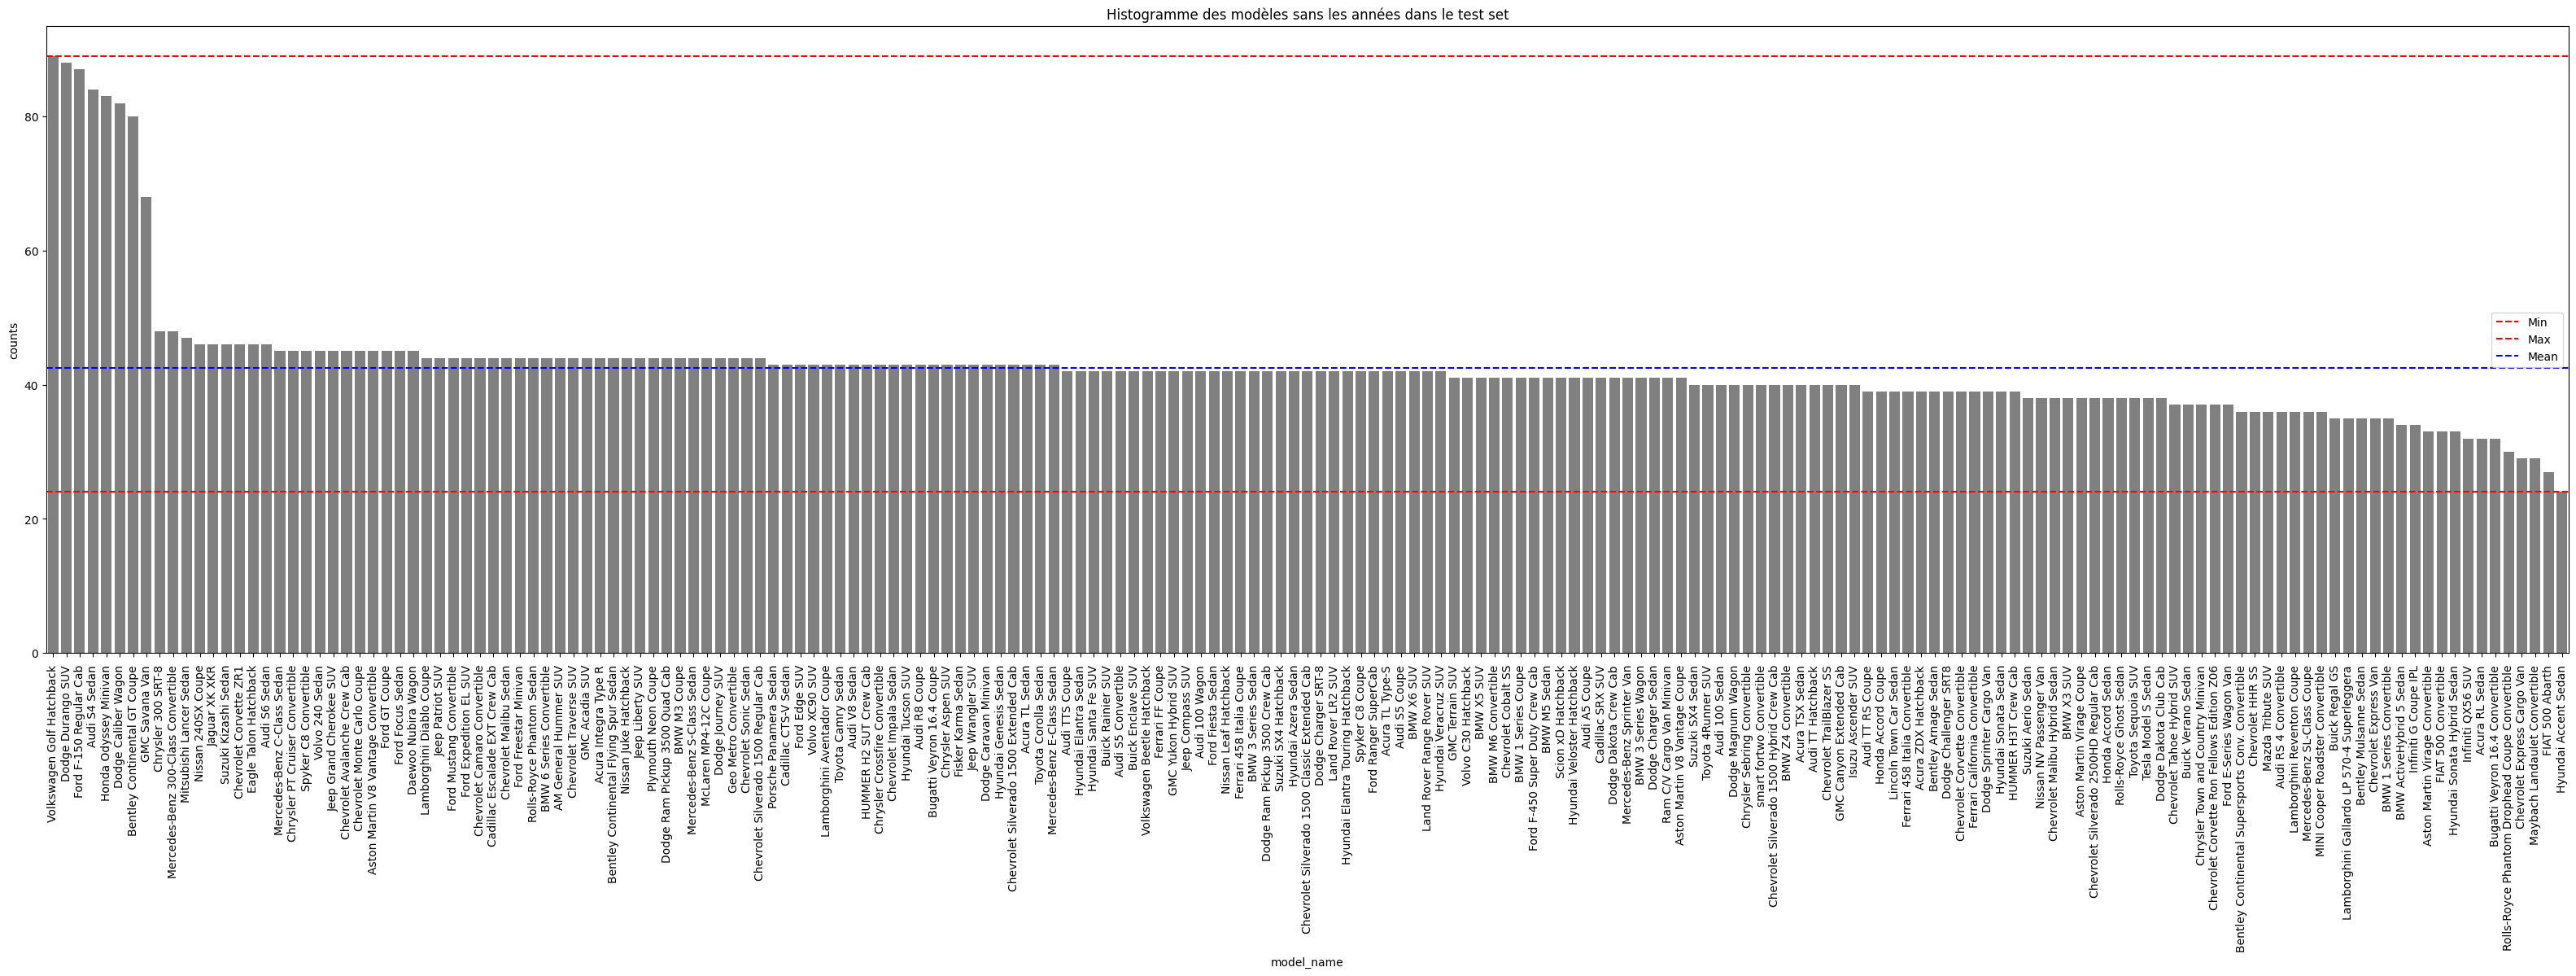

In [316]:
plot_class_count(test, col='model_name', title='Histogramme des modèles sans les années dans le test set')

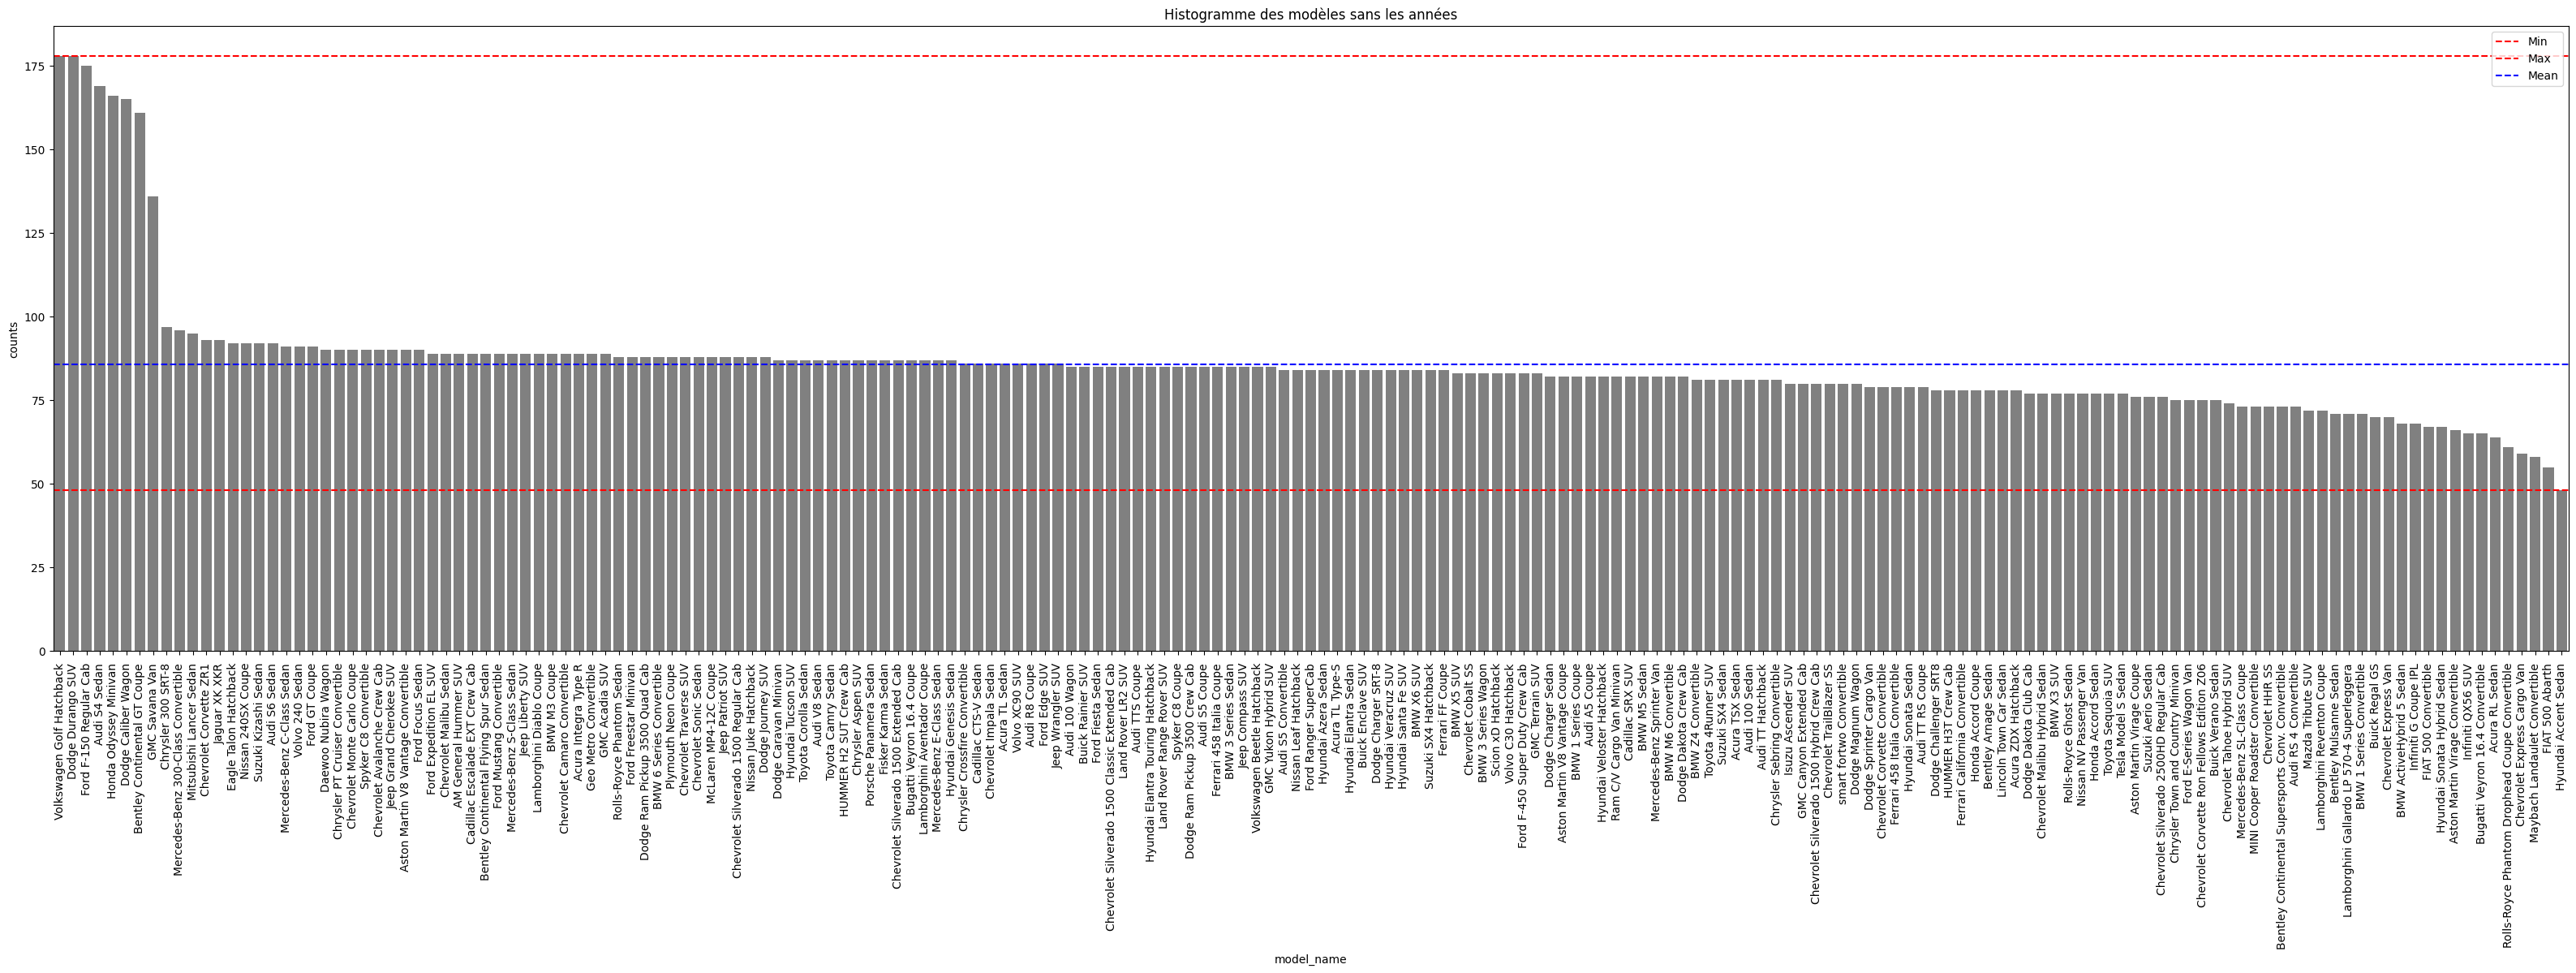

In [321]:
plot_class_count(df, col='model_name', title='Histogramme des modèles sans les années')

## Distribution des marques

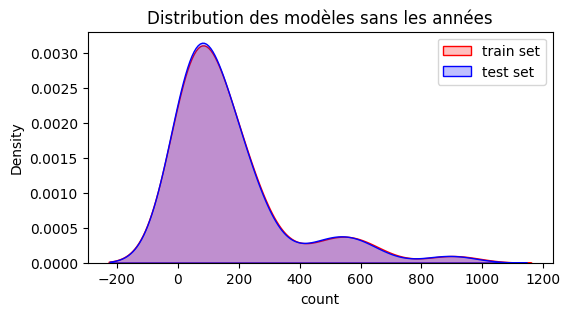

In [347]:
distribution_df(train, test, col='marque', title='Distribution des modèles sans les années')

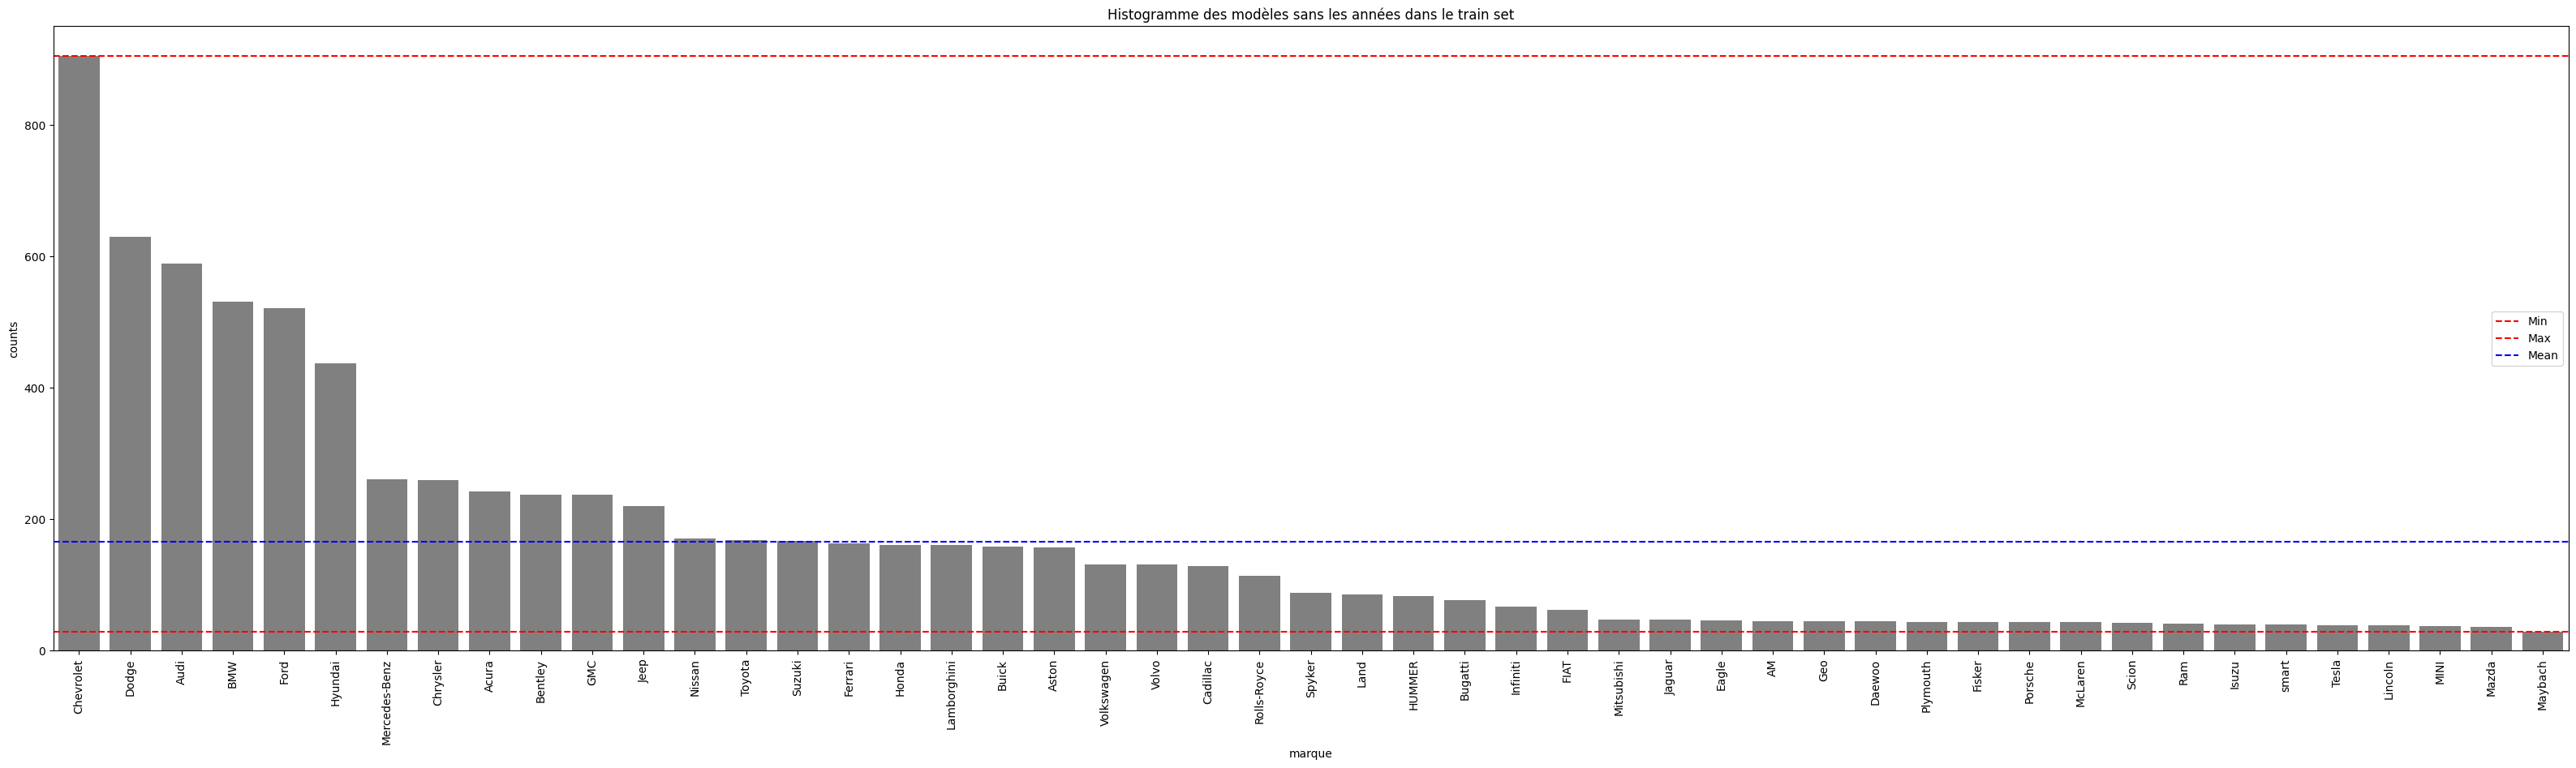

In [318]:
plot_class_count(train, col='marque', title='Histogramme des modèles sans les années dans le train set')

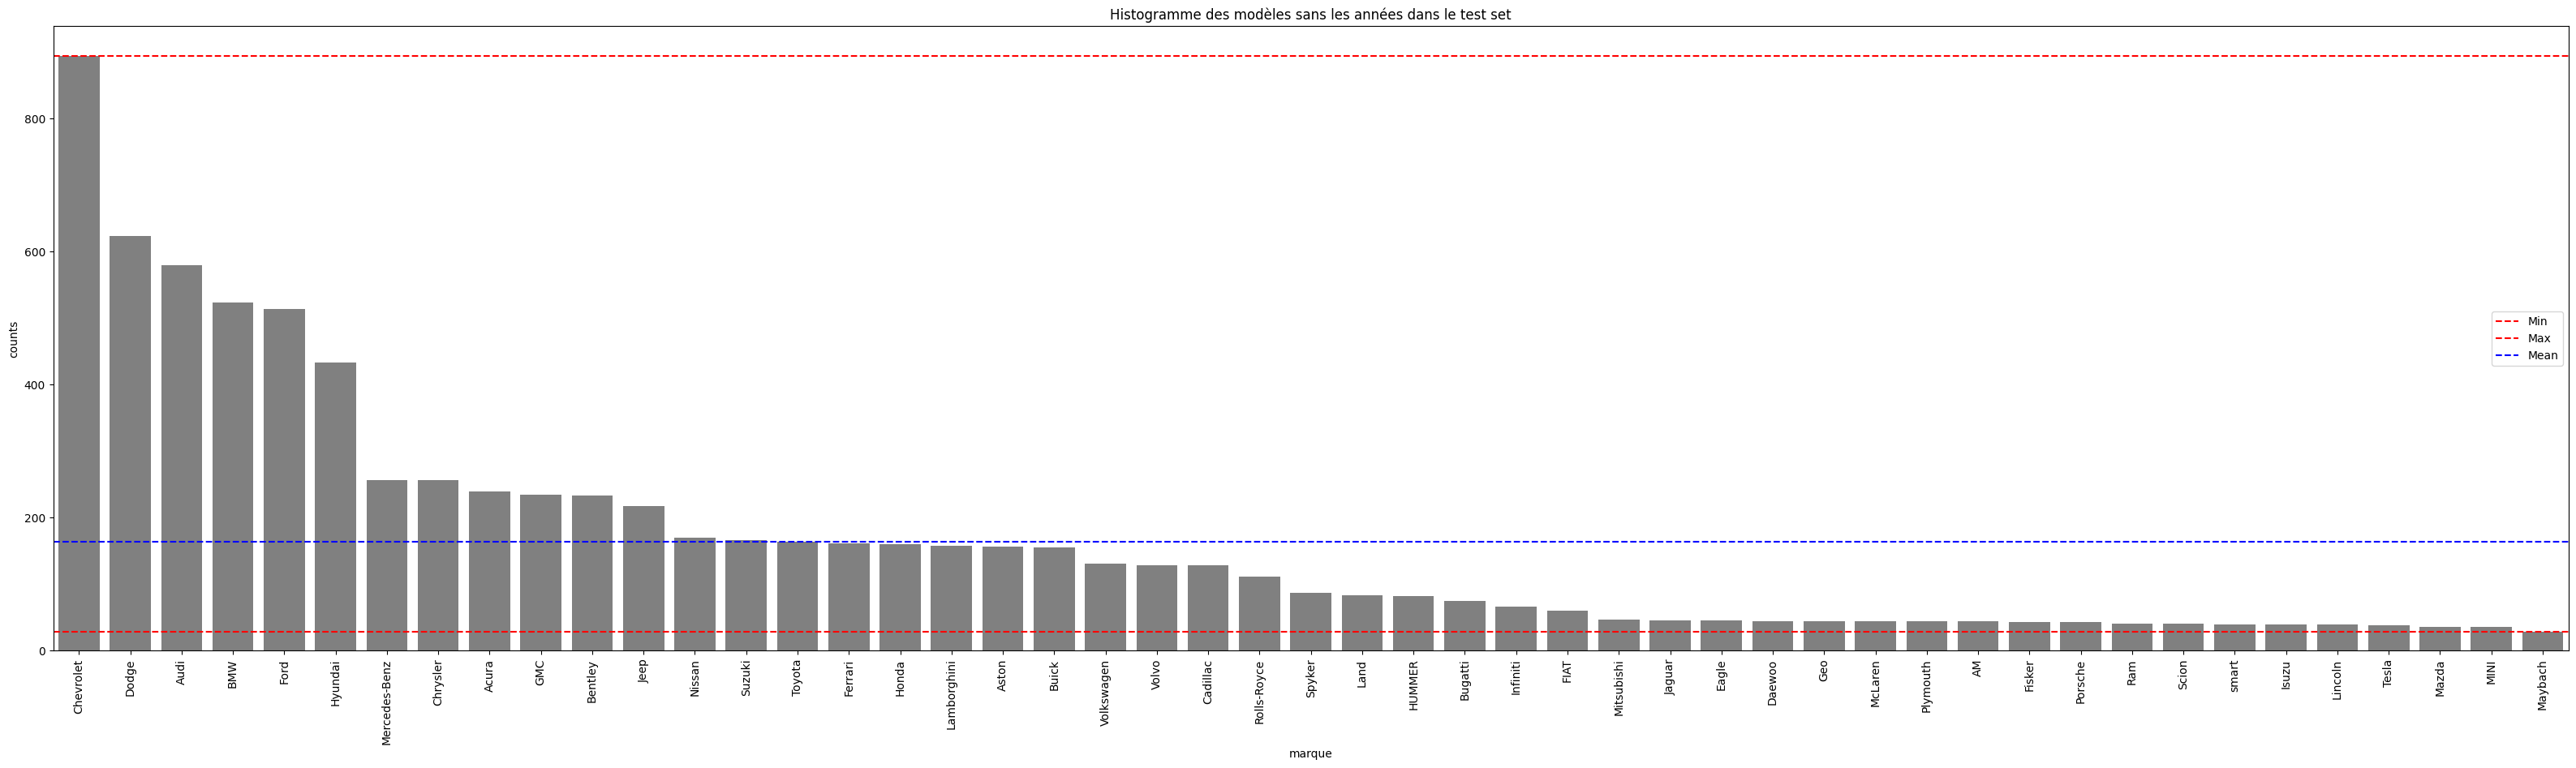

In [319]:
plot_class_count(test, col='marque', title='Histogramme des modèles sans les années dans le test set')

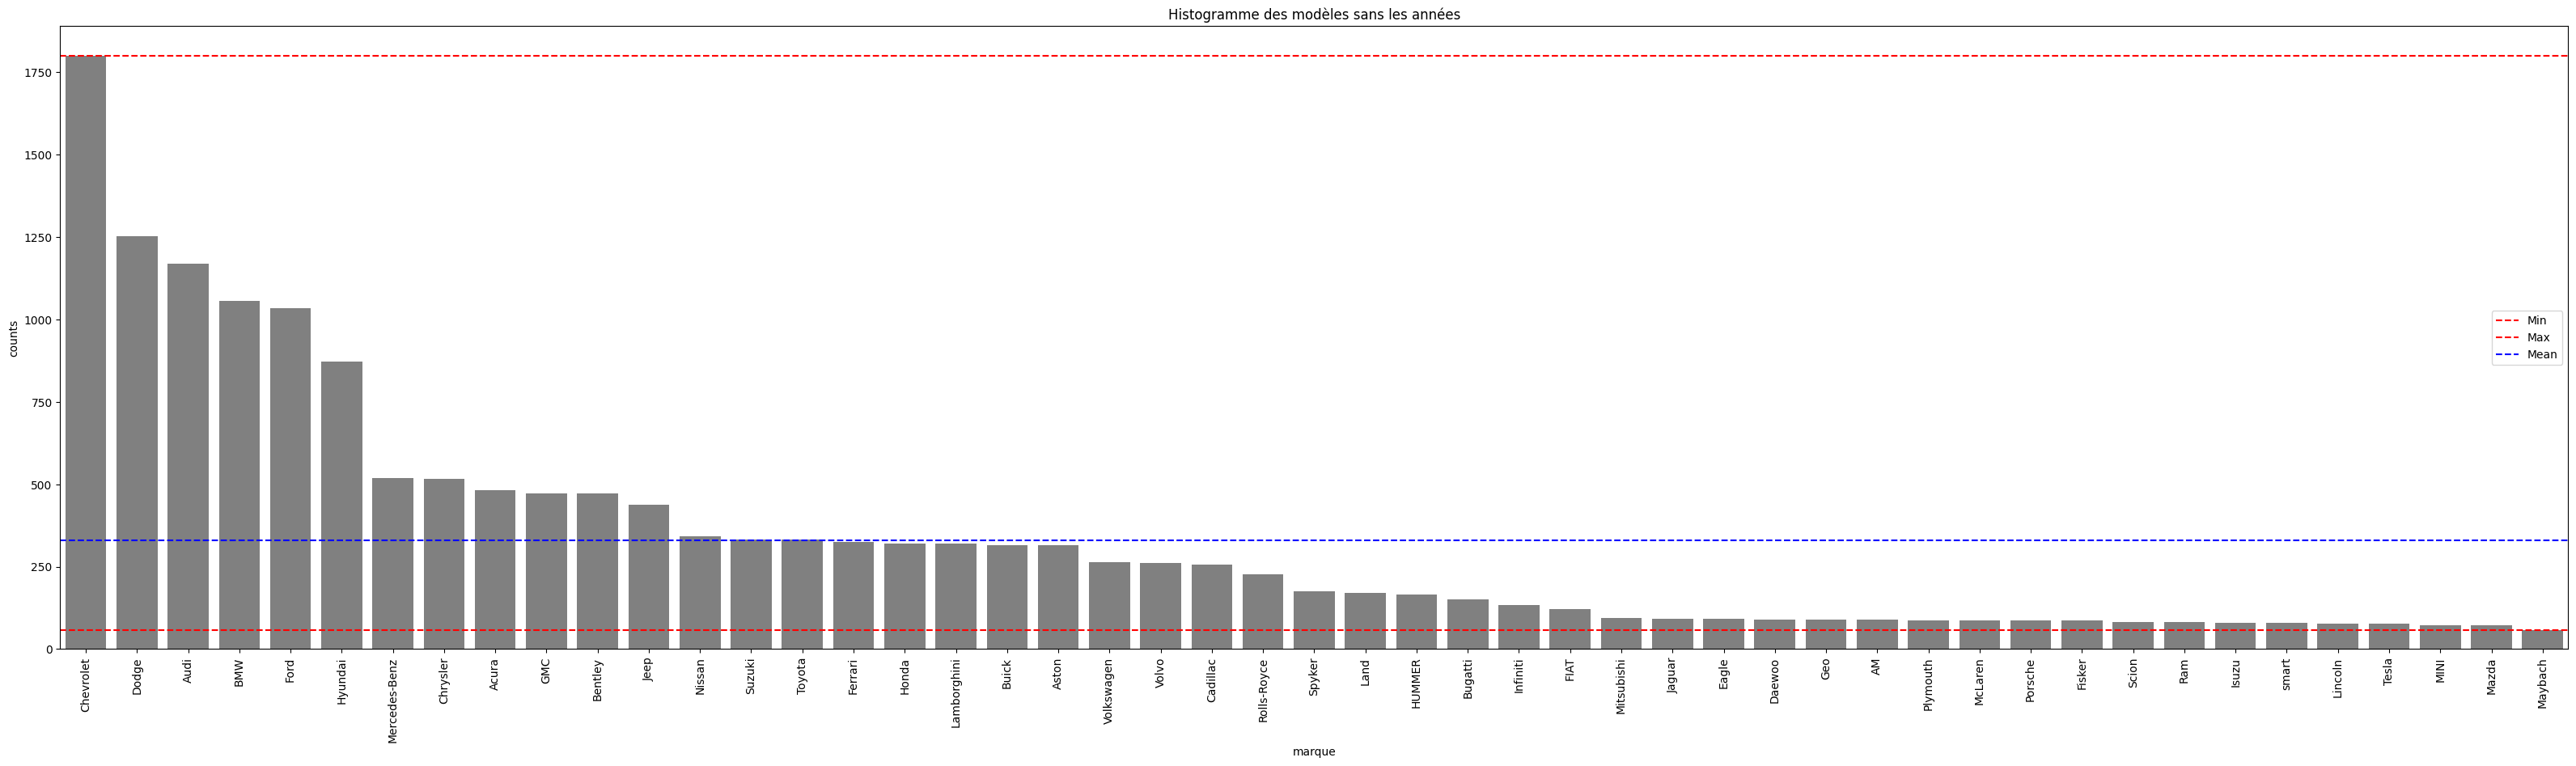

In [320]:
plot_class_count(df, col='marque', title='Histogramme des modèles sans les années')

## Analyse du comportement du modèle

In [16]:
error_df = pd.read_csv('error_df_best_model.csv')

In [17]:
def create_variable_for_error(df, col):
    df[col+'_year'] = df[col+'_name'].str.extract(r'(\b\d{4}\b)$')
    df[col+'_model_name'] = df[col+'_name'].str.replace(r'\b\d{4}\b$', '', regex=True)
    df[col+'_marque'] = df[col+'_model_name'].str.extract(r'^(\w+(-\w+)?)')[0]
    return df

In [18]:
error_df = create_variable_for_error(error_df, 'Prediction')
error_df = create_variable_for_error(error_df, 'Label')

### Analyse des erreurs en fonction des catégories

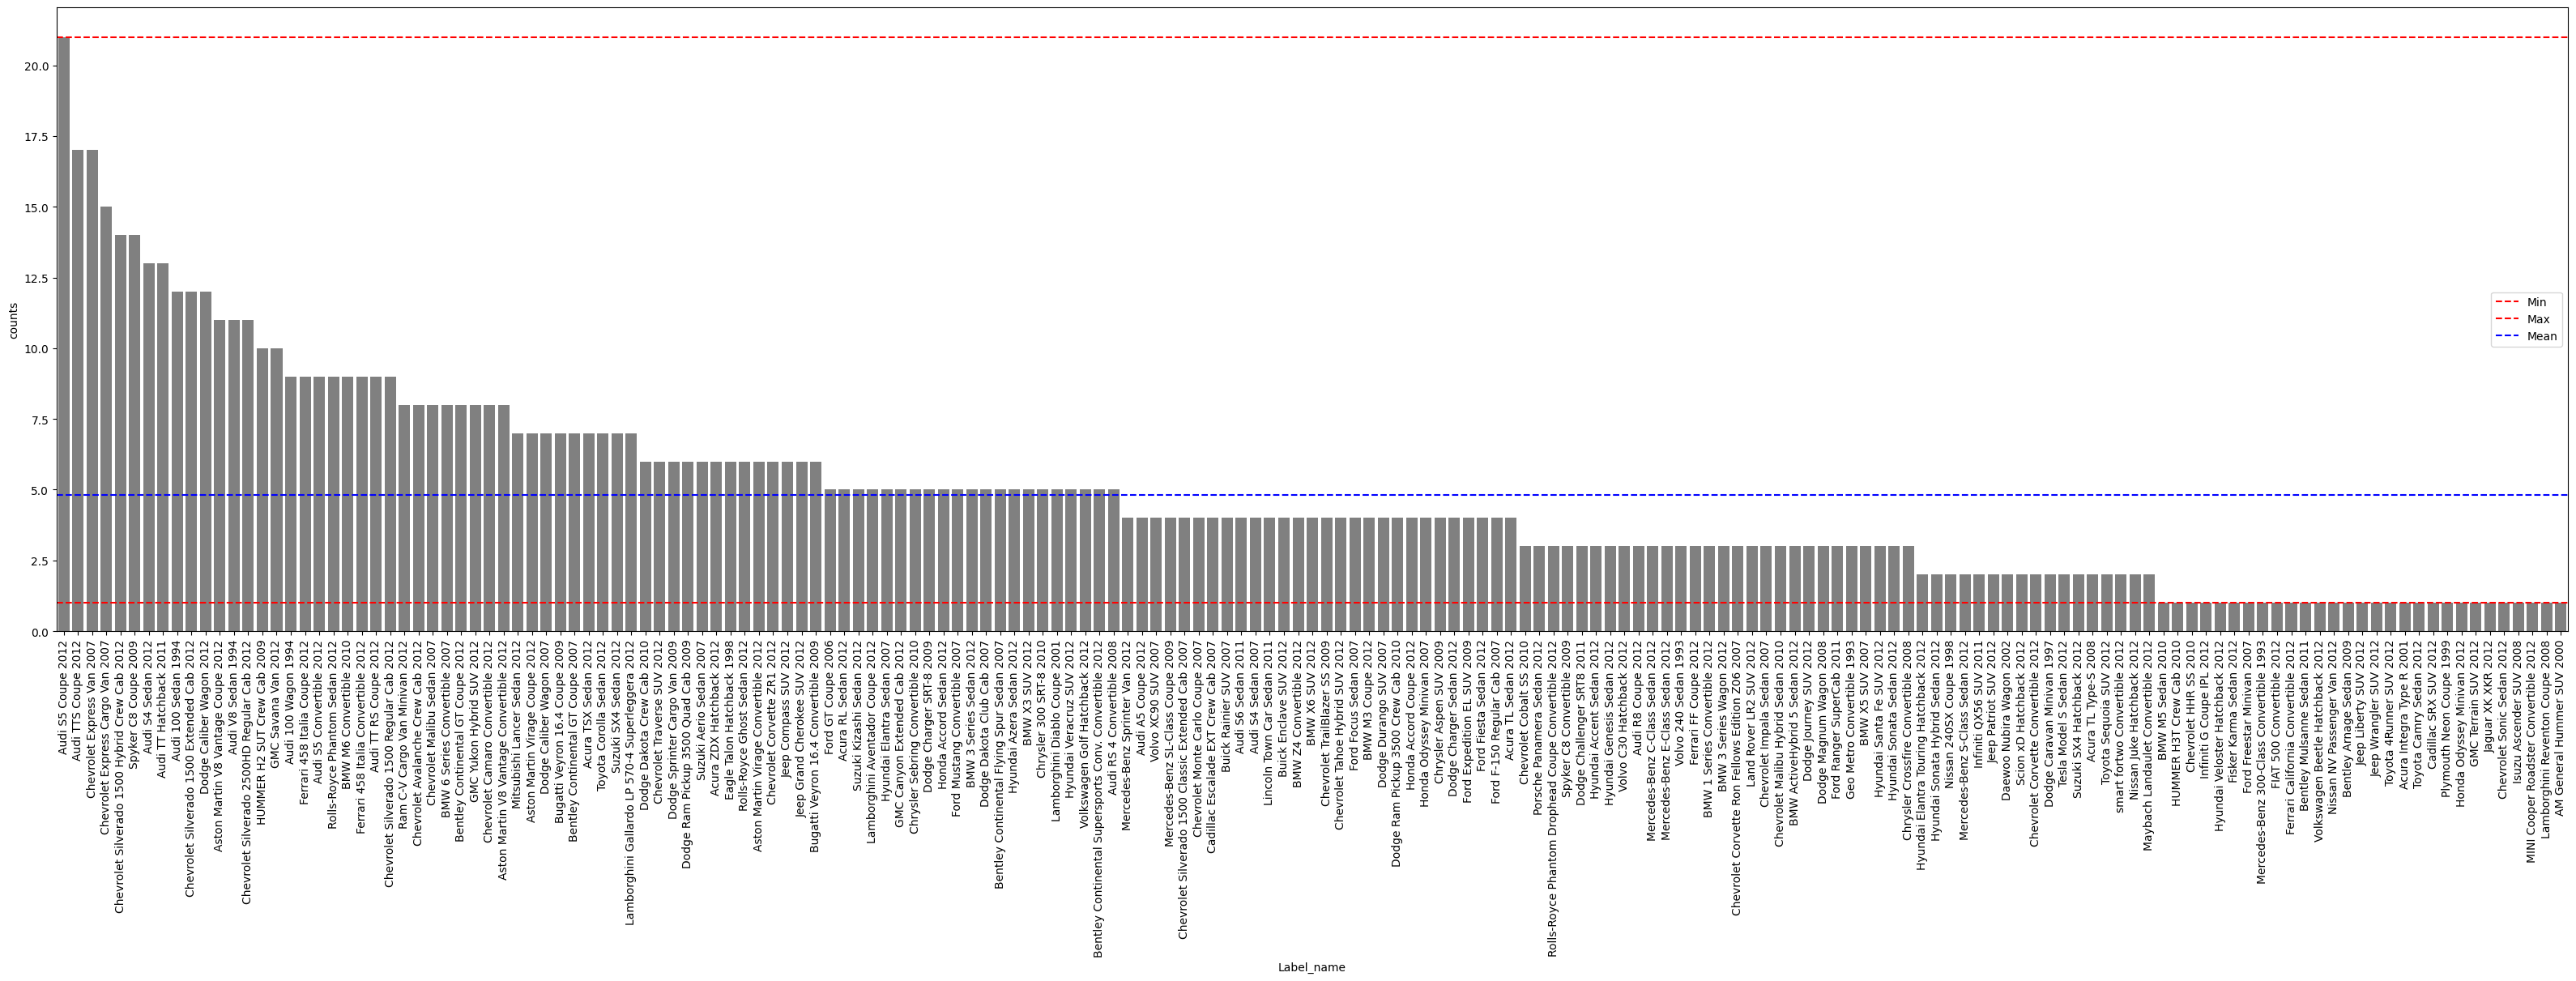

In [28]:
plot_class_count(error_df, 'Label_name', '')

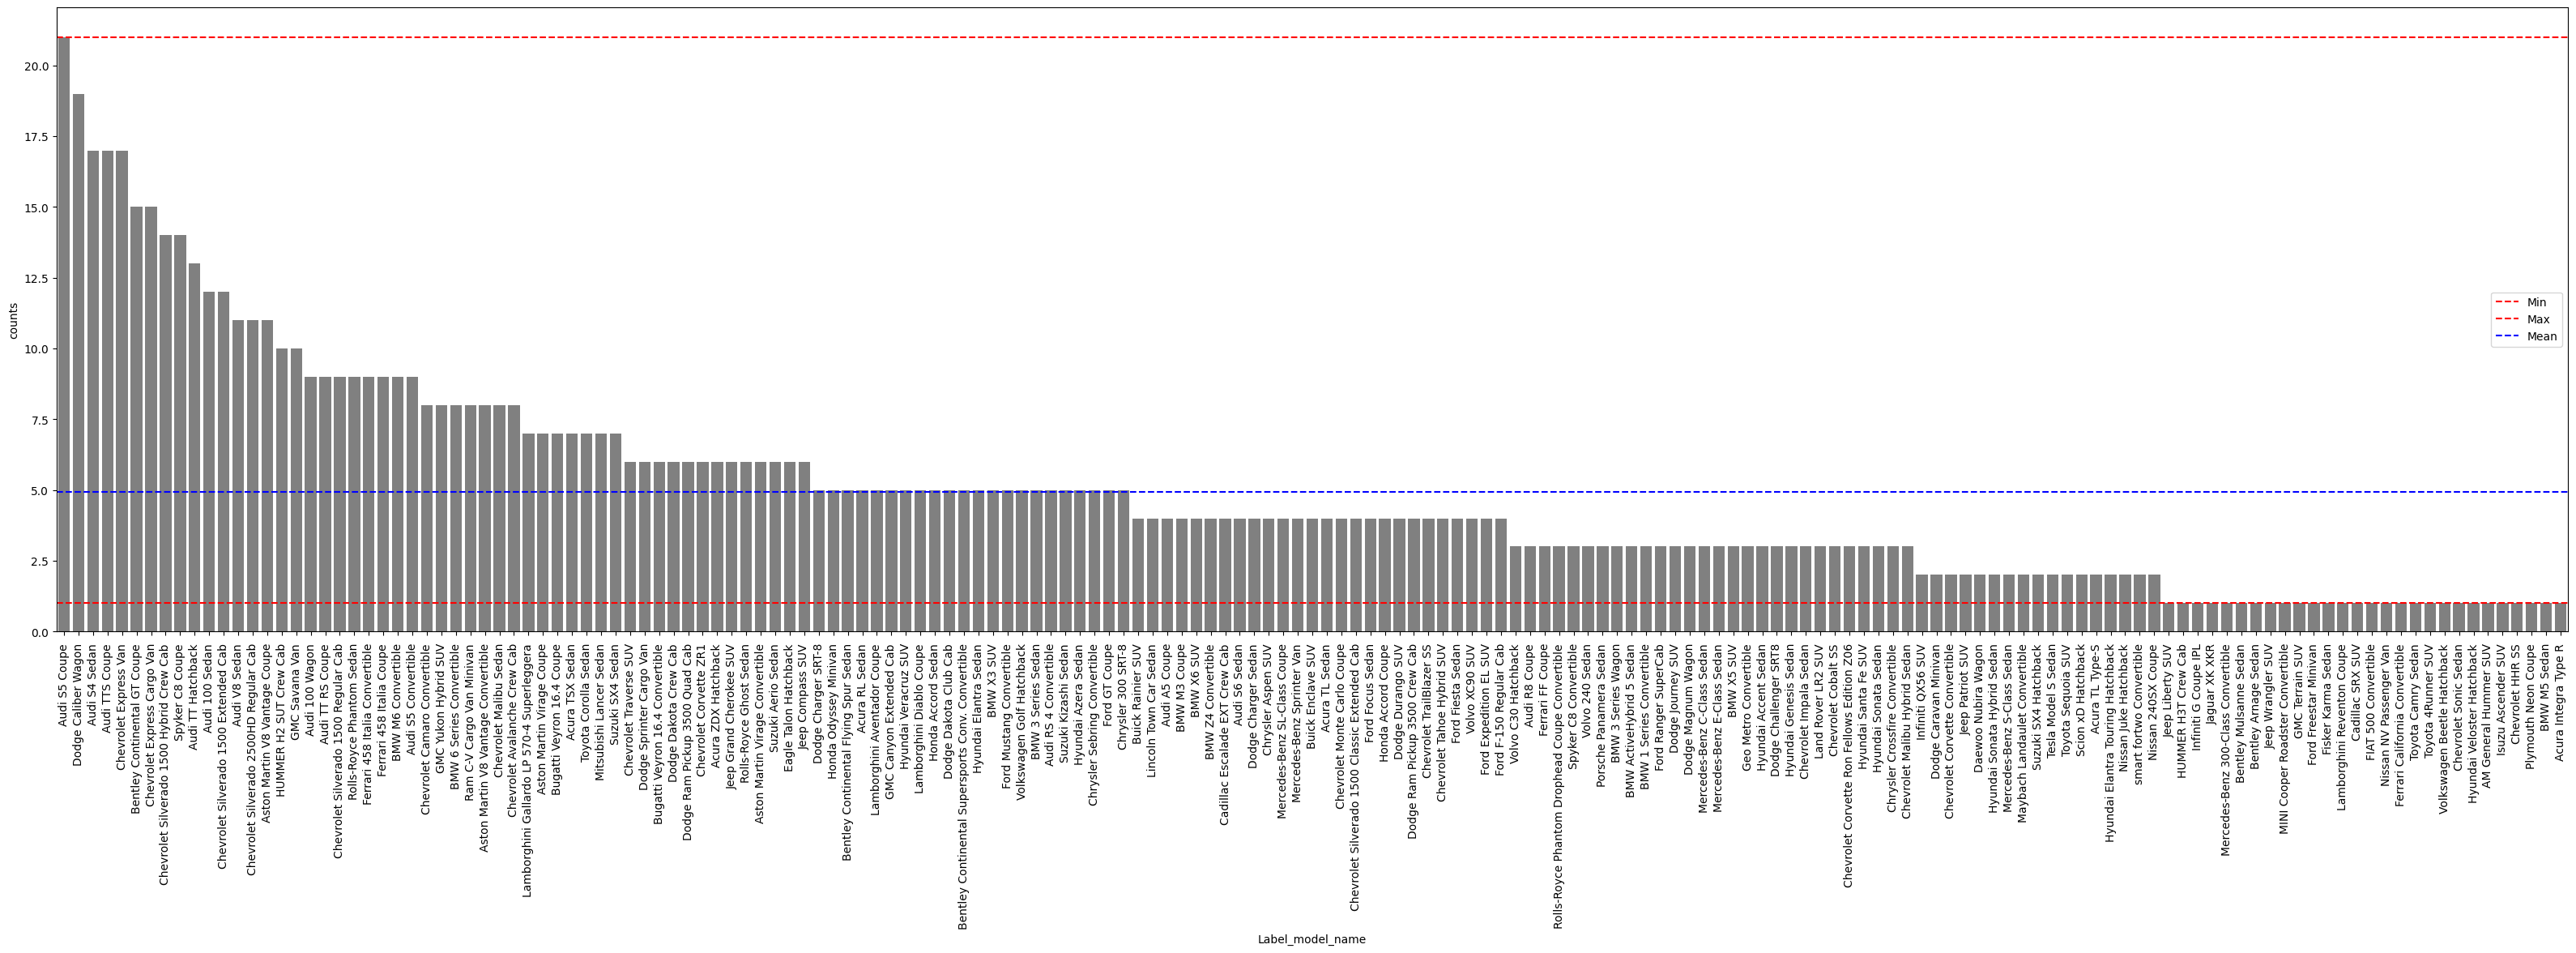

In [29]:
plot_class_count(error_df, 'Label_model_name', '')

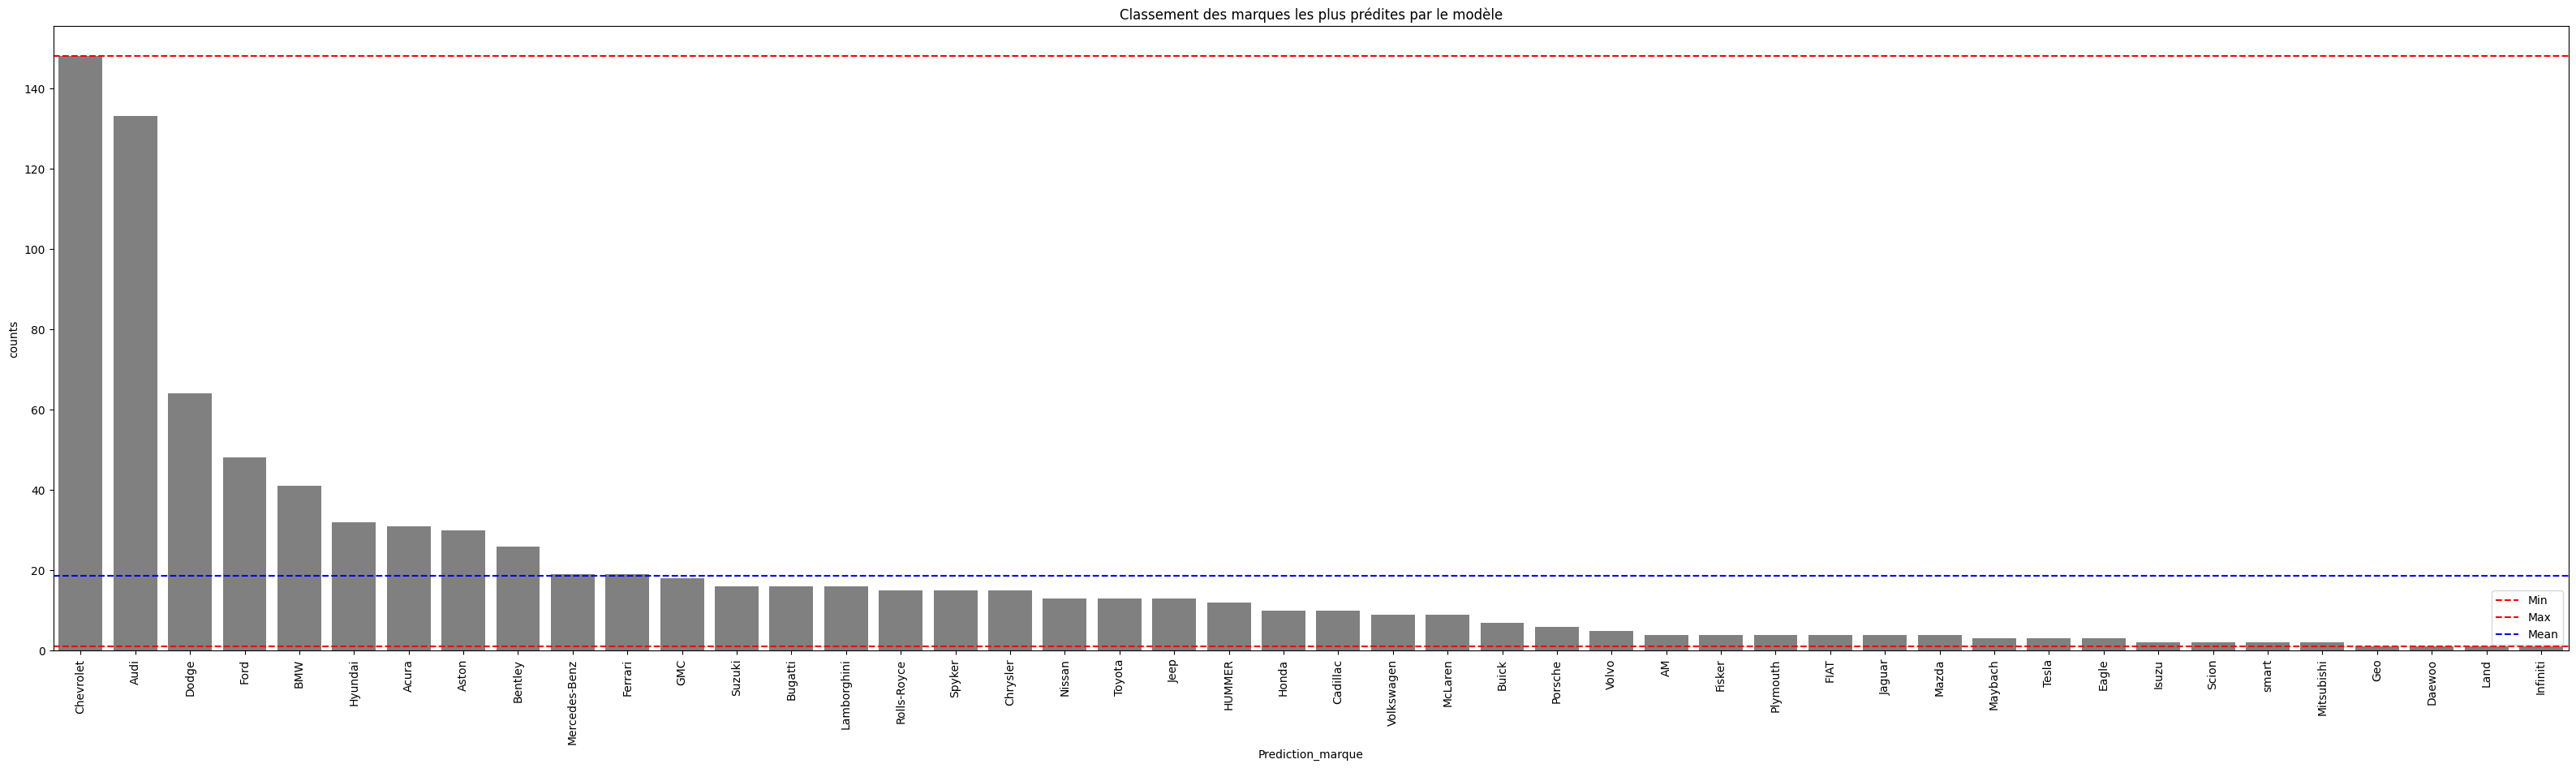

In [22]:
plot_class_count(error_df, 'Prediction_marque', 'Classement des marques les plus prédites par le modèle')

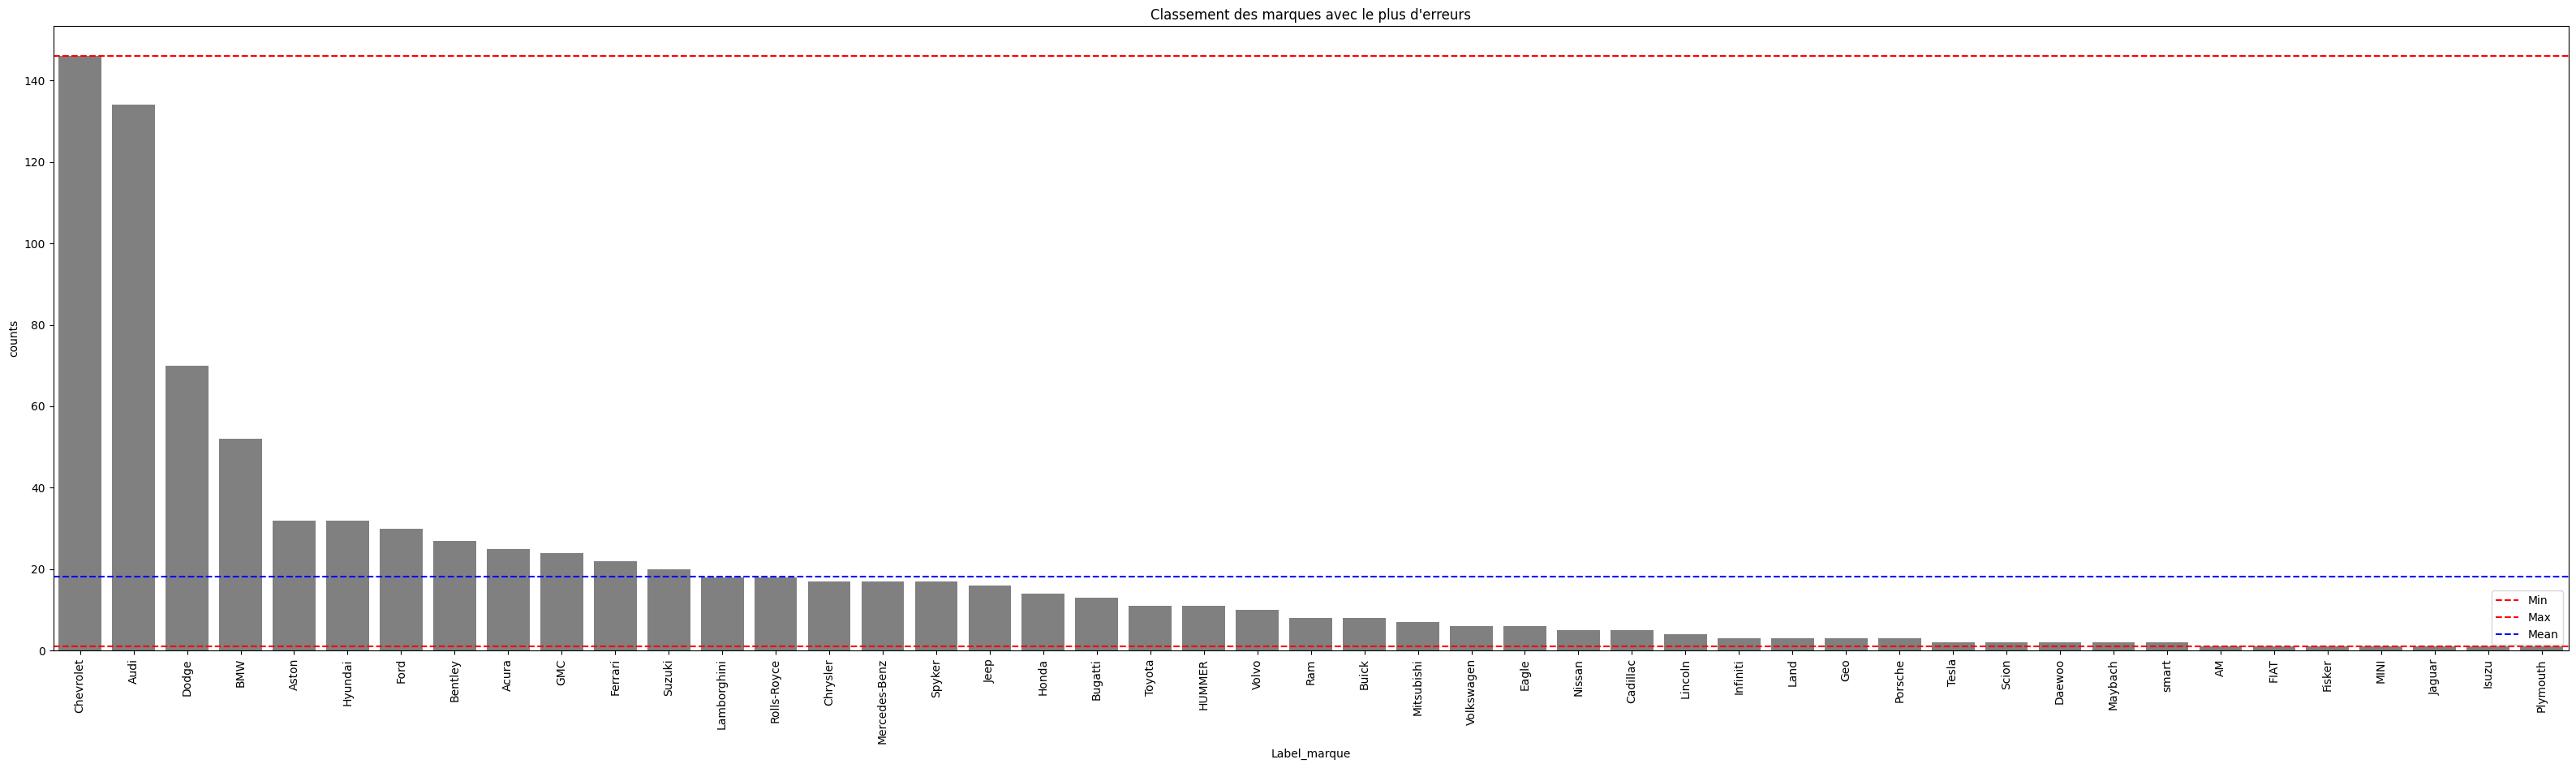

In [21]:
plot_class_count(error_df, 'Label_marque', 'Classement des marques avec le plus d\'erreurs')

In [ ]:
fig = plt.figure(figsize=(40, 10))
col = 'marque'

total_counts = df['marque'].value_counts().sort_values(ascending=False).reset_index()
total_counts.columns = [col, 'counts'] 

error_counts = error_df['Label_marque'].value_counts().sort_values(ascending=False).reset_index()
error_counts.columns = [col, 'counts']  

sns.barplot(x=col, y='counts', data=total_counts, color='green', label='proportion de marques bien prédites')
sns.barplot(x=col, y='counts', data=error_counts, color='red', label='proportion de marques mal prédites')
plt.xticks(rotation=90)

plt.title('Représentation des marques et de la proportion d\erreurs de prédictions')
plt.show()

In [ ]:
prop_df = pd.merge(total_counts, error_counts, how='right', on='marque')
prop_df.rename(columns={'counts_x': 'total', 'counts_y': 'erreur_prediction'}, inplace=True)
prop_df['proportion_erreur'] = prop_df['erreur_prediction'] / prop_df['total']

plt.figure(figsize=(12, 5))

# Tracer l'histogramme avec les valeurs triées
order = prop_df.sort_values(by='proportion_erreur', ascending=False)['marque']
sns.barplot(x='marque', y='proportion_erreur', data=prop_df, order=order, color='grey')
plt.xticks(rotation=90)
plt.title('Proportion d\'erreurs dans chaque marque')
plt.show()

In [19]:
good_pred = list(set(df['name'].values) - set(error_df['Prediction_name'].unique()))

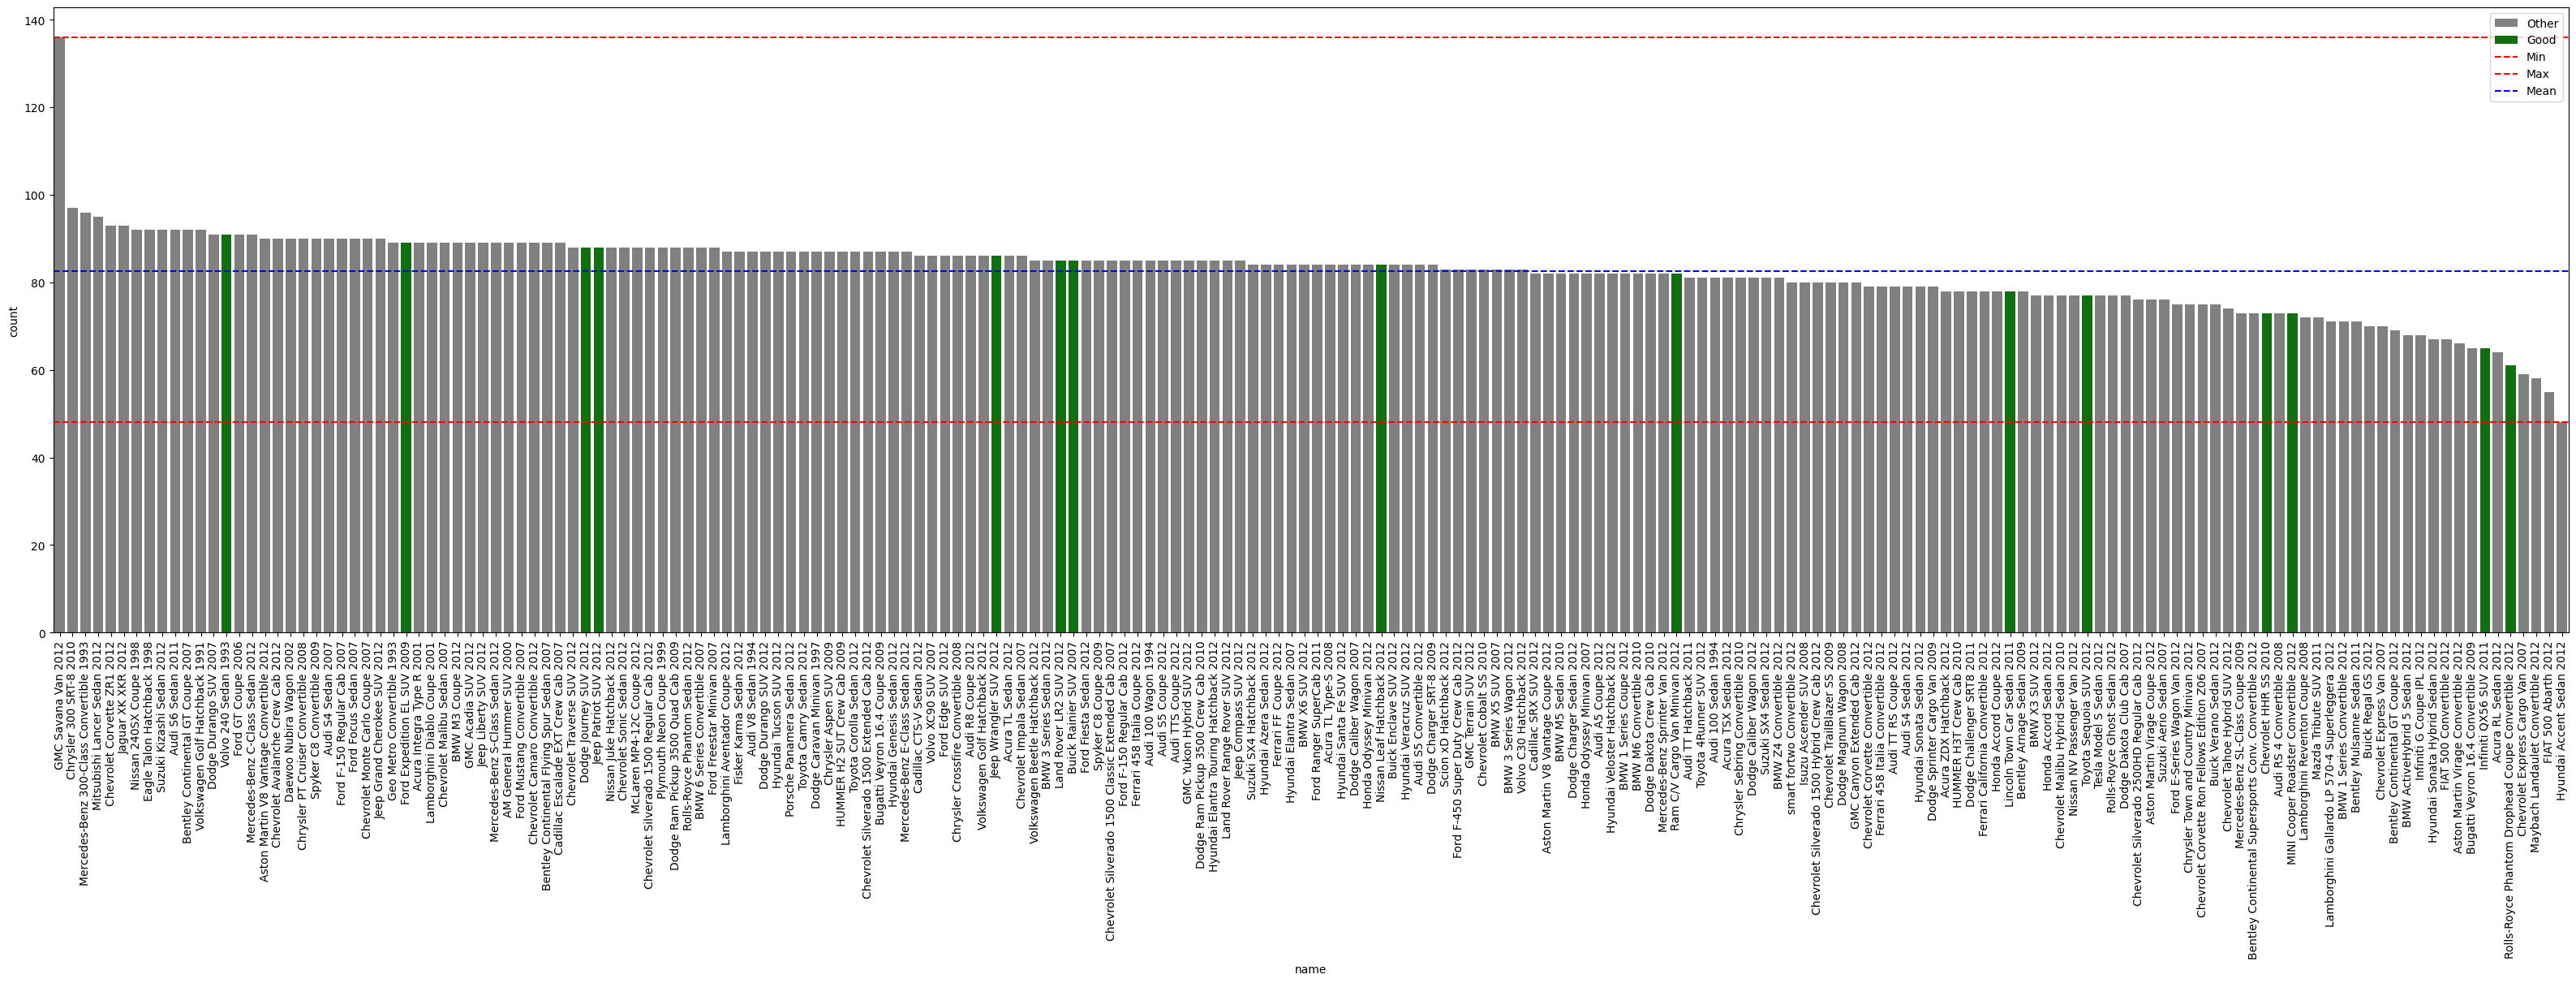

In [101]:
def plot_class_count_(df, col, title, good_pred):
    fig = plt.figure(figsize=(40, 10))
    
    # Tracer l'histogramme avec les valeurs triées
    order = df[col].value_counts().sort_values(ascending=False).index
    df['Color'] = df[col].apply(lambda x: 'Good' if x in good_pred else 'Other')
    palette = {'Good':'green', 'Other':'grey'}
    sns.countplot(data=df, x=col, order=order, hue='Color', palette=palette)    
    plt.xticks(rotation=90)

    value_counts = df[col].value_counts()
    min_val = value_counts.min()
    max_val = value_counts.max()
    mean_val = value_counts.mean()

    # Tracer les lignes pour min, max et mean
    plt.axhline(min_val, color='red', linestyle='--', label='Min')
    plt.axhline(max_val, color='red', linestyle='--', label='Max')
    plt.axhline(mean_val, color='blue', linestyle='--', label='Mean')
    plt.title(title)
    plt.legend()
    plt.show()


plot_class_count_(df, 'name', '', good_pred)

## Analyse des erreurs Intra-Classe

Le graphe nous indique 2 cas:

- cas 1: le modèle a réussi a trouvé le modèle sans l'année mais peine a trouver la bonne année de modèle

- cas 2: le modèle a réussi a trouvé la marque de la voiture mais peine à trouver le bon modèle (sans l'année)

Dans le cas 2 il y'a plus d'erreurs que dans le cas 1. Nous pouvons retenir que notre modèle est très performant pour trouver la marque de voiture, mais la détection du modèle sans l'année reste à désirer. Dans la suite de notre travail, pour pouvoir réduire notre erreur intra-classe, nous allons développer un modèle spécialiser dans la tétection de classe pour des marques spécifiques.

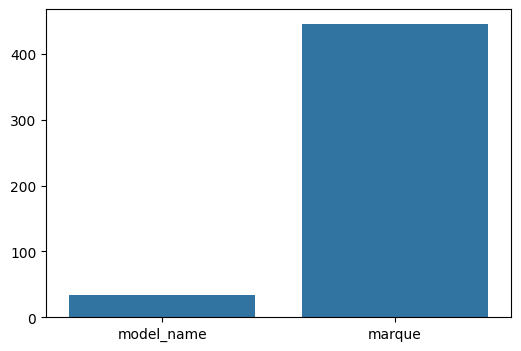

In [125]:
import warnings
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue` is deprecated")
err_counts = []
err_type = ['model_name', 'marque']

for t in err_type:
    nb = len(error_df[error_df['Prediction_'+t]==error_df['Label_'+t]])
    err_counts.append(nb)

plt.figure(figsize=(6, 4))
sns.barplot(y=err_counts, x=err_type)
plt.show()

In [149]:
def lien_data_perf(df, error_df, col):
    existants = pd.DataFrame({col: df[col].unique()})

    occ_err_df = pd.merge(existants, df[col].value_counts(), on=col, how='left').fillna(0)
    occ_err_df = pd.merge(occ_err_df, error_df['Label_'+col].value_counts(), 
                          left_on=col, right_on='Label_'+col, how='left').fillna(0)
    
    occ_err_df.rename(columns={'count_x': '#occurrence', 'count_y': '#erreur'}, inplace=True)
    return occ_err_df

In [ ]:
lien_marque = lien_data_perf(df, error_df, 'marque')
lien_model_name = lien_data_perf(df, error_df, 'model_name')
lien_name = lien_data_perf(df, error_df, 'name')

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
x, y = '#occurrence', '#erreur'

sns.scatterplot(data=lien_marque, x=x, y=y, color='blue', ax=axes[0, 0])
sns.regplot(data=lien_marque, x=x, y=y, color='blue', ax=axes[0, 0], scatter=False)
sns.kdeplot(data=lien_marque, x=x, y=y, color='blue', ax=axes[1, 0])
axes[0, 0].set_title('#erreurs selon la prédominance des marques')

sns.scatterplot(data=lien_model_name, x=x, y=y, color='green', ax=axes[0, 1])
sns.regplot(data=lien_model_name, x=x, y=y, color='green', ax=axes[0, 1], scatter=False)
sns.kdeplot(data=lien_model_name, x=x, y=y, color='green', ax=axes[1, 1])
axes[0, 1].set_title('#erreurs selon la prédominance des model_name (sans year)')

sns.scatterplot(data=lien_name, x=x, y=y, color='brown', ax=axes[0, 2])
sns.regplot(data=lien_name, x=x, y=y, color='brown', ax=axes[0, 2], scatter=False)
sns.kdeplot(data=lien_name, x=x, y=y, color='brown', ax=axes[1, 2])
axes[0, 2].set_title('#erreurs selon la prédominance des classes')

plt.tight_layout()
plt.show()